In [1]:
import os
from glob import glob
import numpy as np
from read_roi import read_roi_file, read_roi_zip
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
import imageio
import cv2

from scipy.interpolate import UnivariateSpline, interp1d
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.ndimage.morphology import distance_transform_edt

from sklearn.metrics import auc
from skimage import morphology, exposure
from skimage.draw import line
from skimage.transform import hough_line, hough_line_peaks

from flowmap_utils import *
from kymograph_utils import *

## 0. Refine Stabilization 

In [ ]:
# load .tif video
tif_path =  '/Volumes/T7_LH/Michaela_ Microvascular Timepoints/Processed/Timepoint 0 Green0004 24-11-15 10-05-41 1 to 600.tif'
video = tifffile.imread(tif_path)
print('Video shape:', video.shape)

# load translation file
translation_file = '/Volumes/T7_LH/Michaela_ Microvascular Timepoints/Processed/Timepoint 0 Green0004 24-11-15 10-05-41 1 to 600.csv'
translation = pd.read_csv(translation_file)
slices, x, y  = translation['Slice'].values, translation['dX'].values, translation['dY'].values
sort_idx = np.argsort(slices)
slices, x, y = slices[sort_idx], x[sort_idx], y[sort_idx]
offsets = dict()
for si, xi, yi in zip(slices, x, y):
    offsets[si] = (xi, yi)

# apply translation to video
video_translated = []
for fi, frame in enumerate(video):
    if (fi+1) in offsets:
        dx, dy = offsets[fi+1]
        frame = cv2.warpAffine(frame, np.float32([[1, 0, dx], [0, 1, dy]]), (frame.shape[1], frame.shape[0]))
    video_translated.append(frame)

# save translated video
tifffile.imsave(tif_path.replace('.tif', '_stable.tif'), np.array(video_translated))


Video shape: (600, 1024, 1024)


## 1. Video Loading & Channel Extraction

Video shape: (600, 1024, 1024)


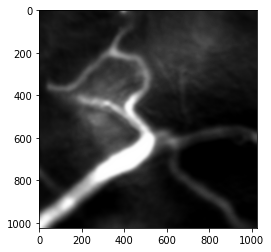

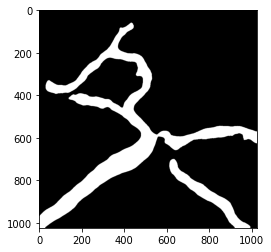

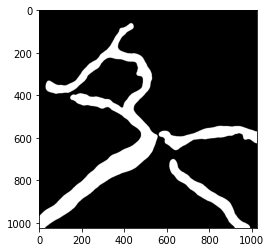

In [3]:
# load .tif video
tif_path = '/Volumes/T7_LH/Michaela_ Microvascular Timepoints/Processed/Timepoint 0 Green0004 24-11-15 10-05-41 1 to 600_stable_cropped.tif'
# '/Volumes/T7_LH/Michaela_ Microvascular Timepoints/Processed/Timepoint 1 Green0004 24-11-15 10-05-41 800 to 1400_stable_cropped.tif'

video = tifffile.imread(tif_path).astype(np.float32)
print('Video shape:', video.shape)

flow = abs(video[1:] - video[:-1])
flow = np.mean(flow, axis=0)
intensity = np.mean(video, axis=0)
intensity -= np.min(intensity)
intensity /= np.max(intensity)

flow = flow / (intensity+1e-5)


flow -= np.percentile(flow, 7.5) #np.min(flow)
flow /= np.percentile(flow, 97.5) #np.max(flow)
flow = np.clip(flow, 0, 1)
flow = (flow * 255).astype(np.uint8)

# # Tophat
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (125, 125))  # Large kernel for background
# flow = cv2.morphologyEx(flow, cv2.MORPH_TOPHAT, kernel)
# # CLAHE
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(51,51))
# flow = clahe.apply(flow)

# gaussian blur
flow = gaussian_filter(flow, 5)

plt.imshow(flow, cmap='gray')
plt.show()

# transfer flow to binary mask by otzu thresholding
# _, binary_mask = cv2.threshold(flow, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
binary_mask = cv2.adaptiveThreshold(flow, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 301, -5)
# from skimage.filters import threshold_sauvola
# # Compute Sauvola's threshold
# window_size = 251  # Size of the local region
# thresh_sauvola = threshold_sauvola(flow, window_size=window_size)

# Apply the threshold to binarize
# binary_mask = (flow > 1.2 * thresh_sauvola).astype(np.uint8) * 255
binary_mask = binary_mask > 0
# plt.imshow(binary_mask, cmap='gray')
# plt.show()
# remove small objects
binary_mask = morphology.remove_small_objects(binary_mask, min_size=10000)
plt.imshow(binary_mask, cmap='gray')
plt.show()

# smooth binary mask contours
binary_mask = morphology.erosion(binary_mask, morphology.disk(11))
binary_mask = morphology.dilation(binary_mask, morphology.disk(11))
# binary_mask = morphology.binary_closing(binary_mask, morphology.disk(15))
plt.imshow(binary_mask, cmap='gray')
plt.show()

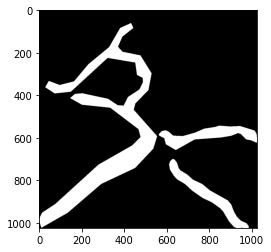

Number of segments: 7


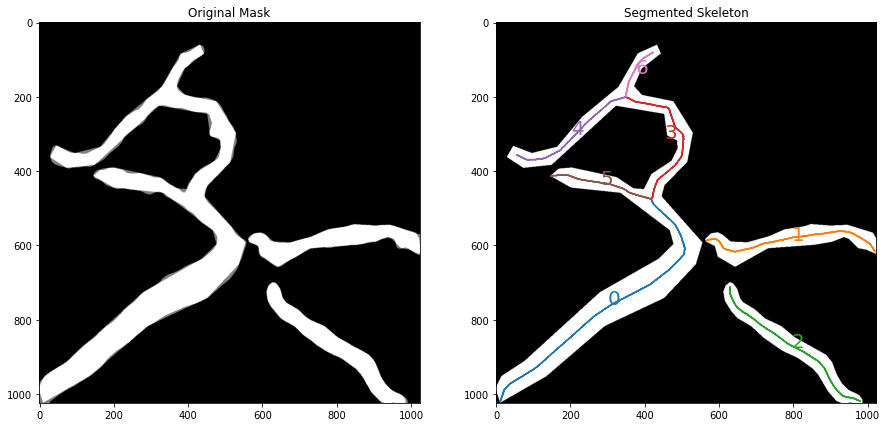

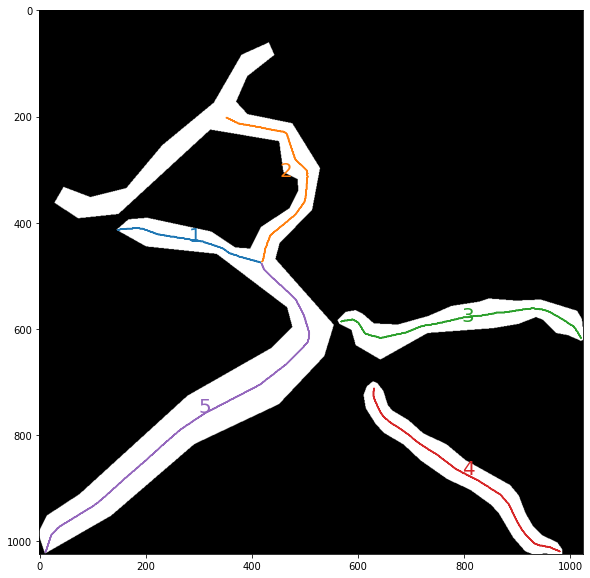

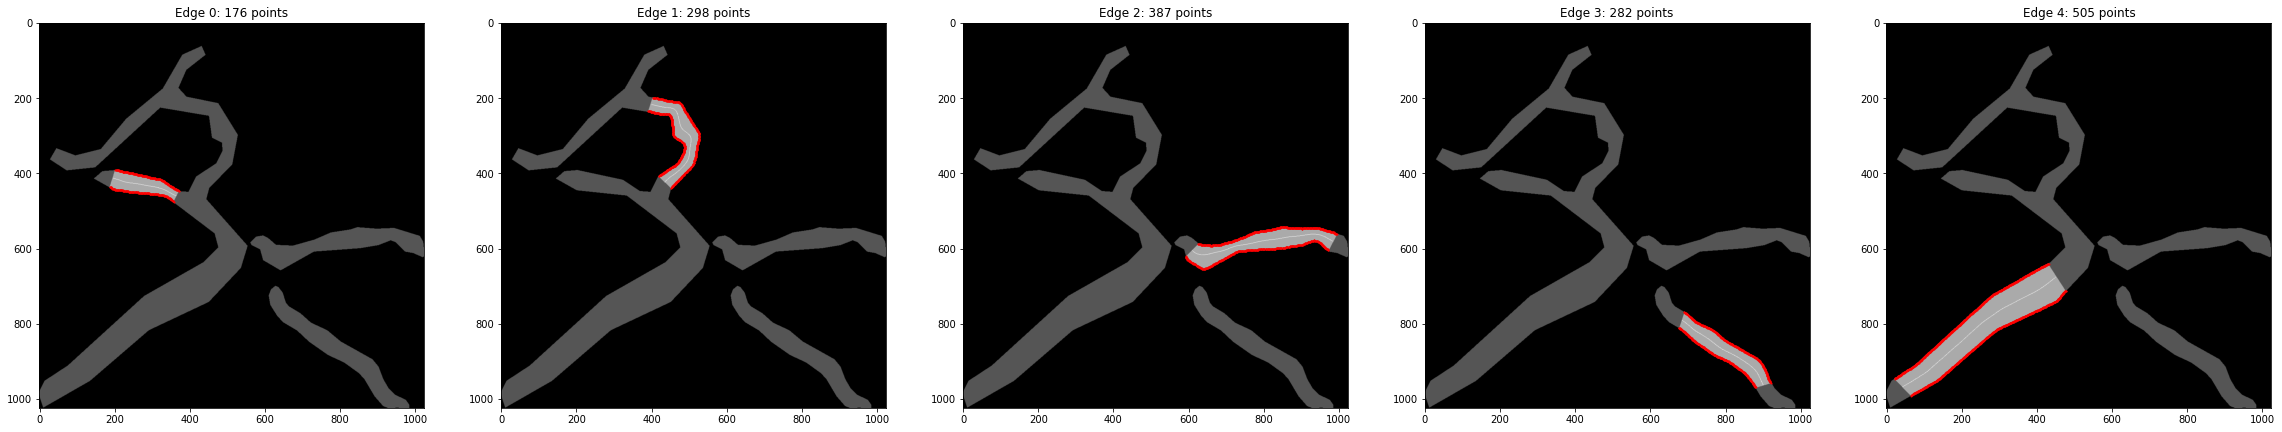

In [4]:
# plantcv
from plantcv import plantcv as pcv
pcv.params.debug = 'noplot'

mask = binary_mask.astype(np.uint8) * 255
mask = smooth_mask(mask, 0.002)
plt.imshow(mask, cmap='gray')
plt.show()

skeleton = pcv.morphology.skeletonize(mask=mask).astype(np.float32) / 255.
# prune and segment the skeleton by breaking at branch points
main_edges, skel_out = skeleton_prunnning(skeleton.astype(np.uint8), mask, len_thresh=50)
print('Number of segments:', len(main_edges))
if True:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
    ske_show = np.repeat(mask[..., np.newaxis], 3, axis=2) * 0.1
    ske_show[:,:,0] += skeleton
    ske_show = np.clip(ske_show, 0, 1)
    plt.subplot(121)
    plt.imshow((binary_mask).astype(np.float32)+mask, cmap='gray')
    plt.gca().set_title('Original Mask')
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    for i, edge in enumerate(main_edges):
        f = ax2.plot(edge[:,0], edge[:,1])
        color = f[0].get_color()
        plt.text(edge[:,0].mean(), edge[:,1].mean(), str(i), color = color, fontsize=20)
    plt.gca().set_title('Segmented Skeleton')
    plt.show()

valid_edges = [5, 3, 1, 2, 0]
main_edges = [main_edges[i] for i in valid_edges]
skel_out_new = np.zeros_like(skel_out)
for ei, edge in enumerate(main_edges):
    for x, y in edge:
        skel_out_new[y, x] = ei+1
skel_out = skel_out_new.astype(np.uint8)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mask, cmap='gray')
for i, edge in enumerate(main_edges):
    f = ax.plot(edge[:,0], edge[:,1])
    color = f[0].get_color()
    plt.text(edge[:,0].mean(), edge[:,1].mean(), str(i+1), color = color, fontsize=20)

'''
Manually select the starting point for each main stem
'''
tip_ids = [0, 0, 1, 1, 0]
'''
Manually cut the segment for each main stem
'''
seg_ids =[[50, -50], [50, -50], [50, -50], [100, -100], [250, -60]]

for ei, main_edge in enumerate(main_edges):
    # detect channel tips to sort flow
    skel_map = (skel_out==ei+1).astype(np.uint8)
    tips = detect_tip_pts(skel_map, vis=False)
    # sort the flow with selected starting point
    sorted_edge = sort_path(main_edge, start=tips[tip_ids[ei]], smooth=30, spacing = 1.)
    main_edges[ei] = sorted_edge.astype(np.int32)

dir_dict = {}
r = 75
figure, ax = plt.subplots(1, len(main_edges), figsize=(40,10))
for ei, sorted_edge in enumerate(main_edges):
    sorted_edge = sorted_edge[seg_ids[ei][0]:seg_ids[ei][1]]
    # get vessel wall realtive to the centerline
    norms = get_normal_direction(sorted_edge, time_window=7)
    seg_mask, vessel_walls, CL = get_vessel_walls(sorted_edge, norms, mask, r)
    dir_dict[ei] = {'CL': CL, 
                    'norms': norms, 
                    'seg_mask': seg_mask,
                    'vessel_walls': vessel_walls}
    # display #2
    if True:
        sorted_edge = dir_dict[ei]['CL']
        edge_map = path_to_img(sorted_edge, mask.shape)
        for wall in dir_dict[ei]['vessel_walls']:
            ax[ei].scatter(wall[:,0], wall[:,1], s=1, c='r')
        ax[ei].imshow(mask+seg_mask+edge_map, cmap='gray')
        ax[ei].set_title(f'Edge {ei}: {len(sorted_edge)} points')
plt.show()


In [9]:
# save points as numpy file
np.save('Flow5_CL.npy', dir_dict[4]['CL'])


## 2. Velocity Estimation

(5, 176, 2)


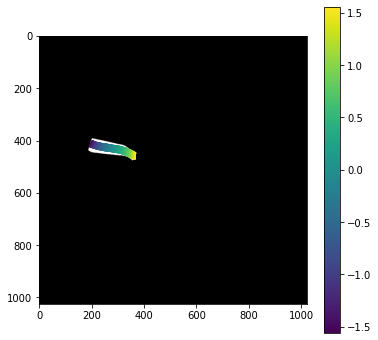

parallel line at -11

Location along the line :79/176; 500/600

parallel line at -5

Location along the line :79/176; 500/600

parallel line at 0

Location along the line :79/176; 500/600

parallel line at 5

Location along the line :79/176; 500/600

parallel line at 11

Location along the line :79/176; 500/600

(5, 1, 56)


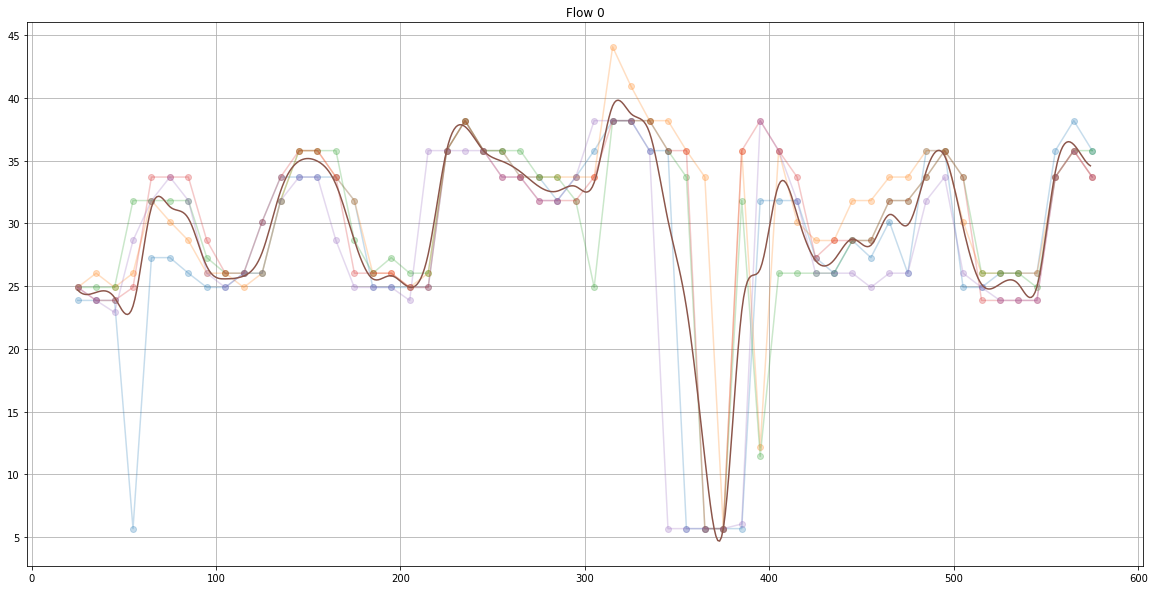

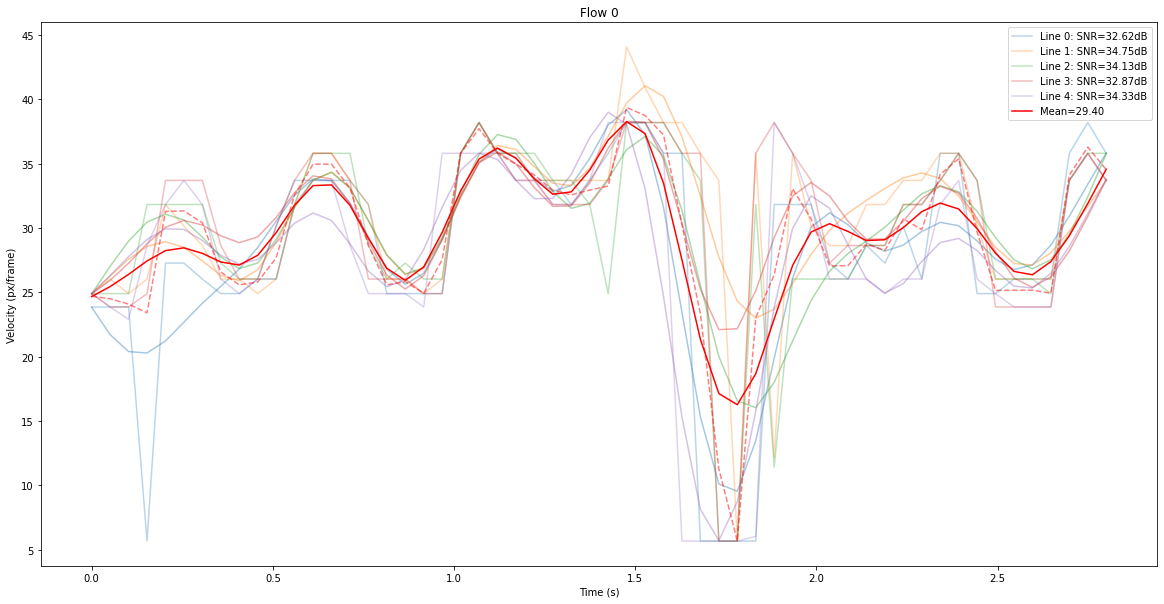

(5, 298, 2)


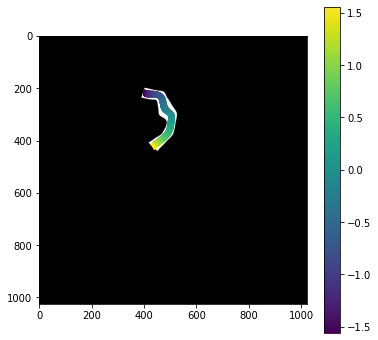

parallel line at -9

Location along the line :134/298; 500/600

parallel line at -4

Location along the line :134/298; 500/600

parallel line at 0

Location along the line :134/298; 500/600

parallel line at 4

Location along the line :134/298; 500/600

parallel line at 9

Location along the line :134/298; 500/600

(5, 1, 56)


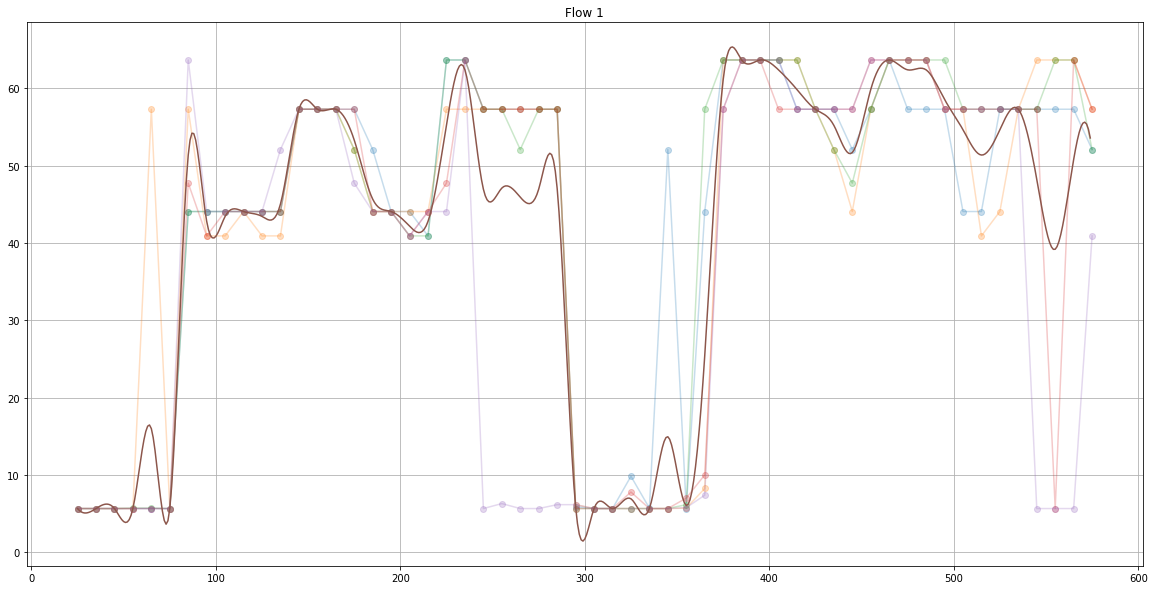

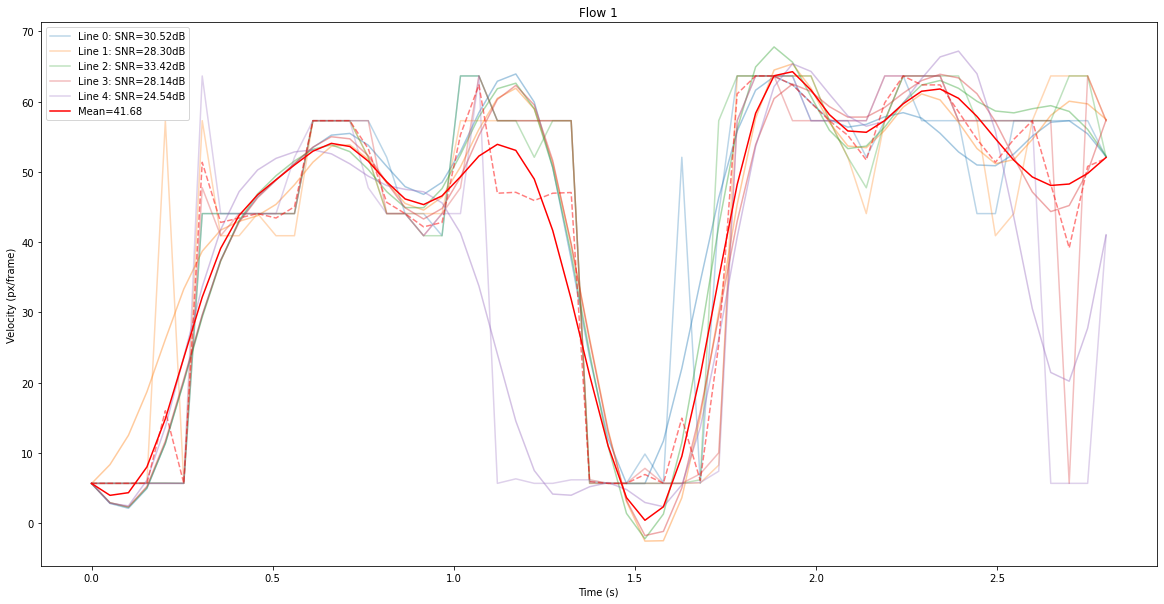

(5, 387, 2)


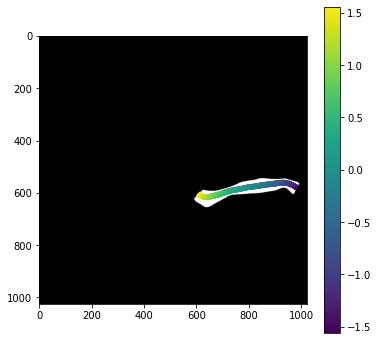

parallel line at -7

Location along the line :174/387; 500/600

parallel line at -3

Location along the line :174/387; 500/600

parallel line at 0

Location along the line :174/387; 500/600

parallel line at 3

Location along the line :174/387; 500/600

parallel line at 7

Location along the line :174/387; 500/600

(5, 1, 56)


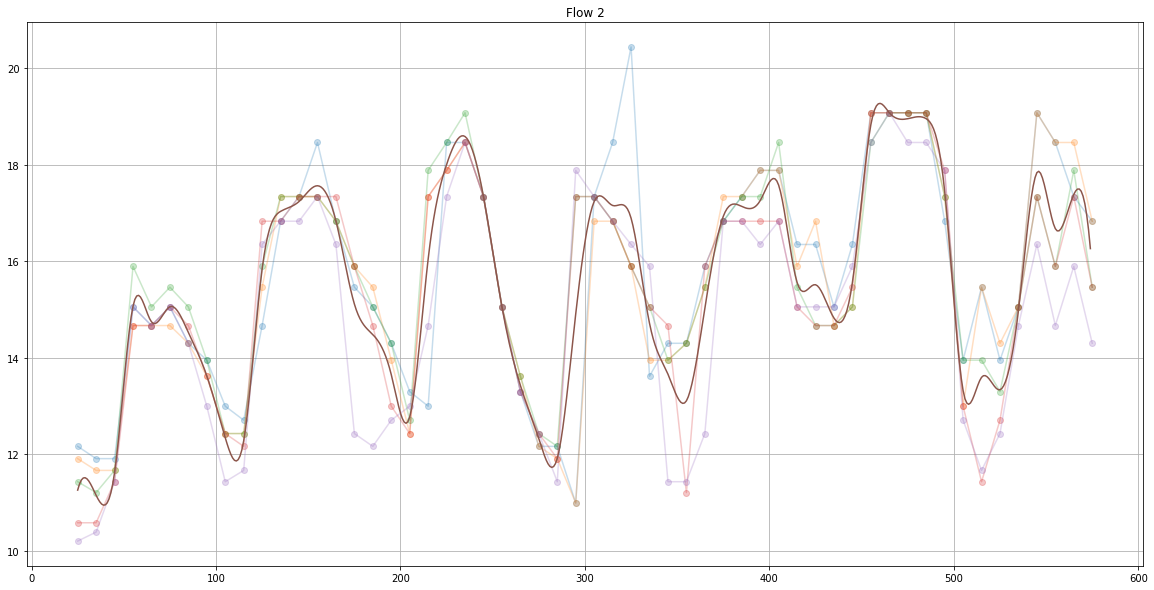

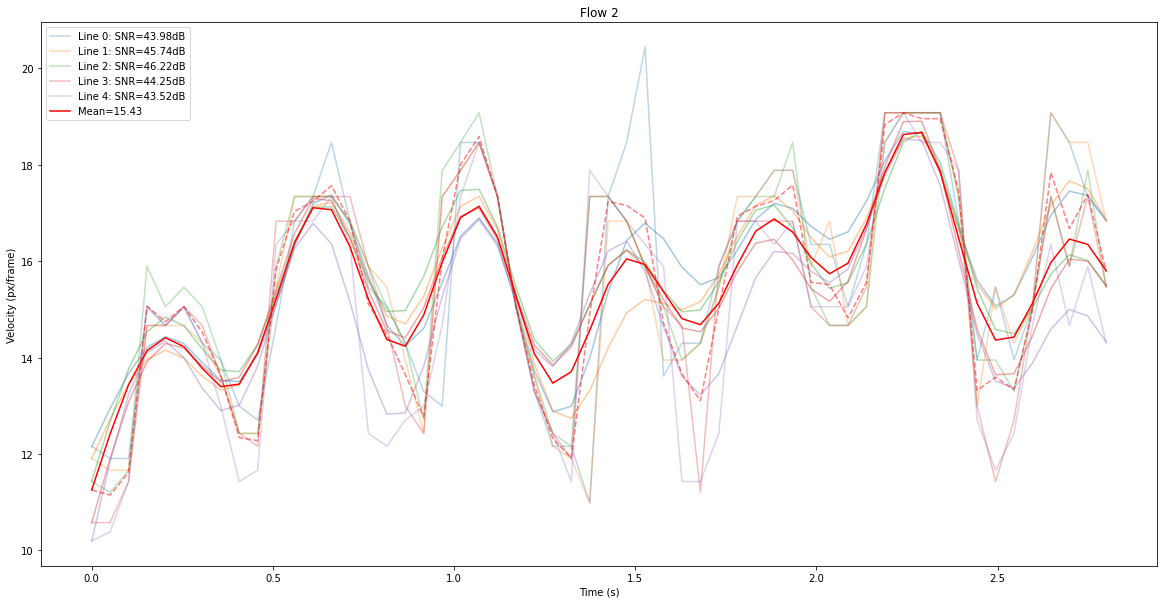

(5, 282, 2)


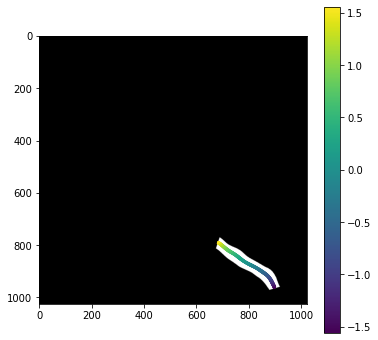

parallel line at -3

Location along the line :127/282; 500/600

parallel line at -1

Location along the line :127/282; 500/600

parallel line at 0

Location along the line :127/282; 500/600

parallel line at 1

Location along the line :127/282; 500/600

parallel line at 3

Location along the line :127/282; 500/600

(5, 1, 56)


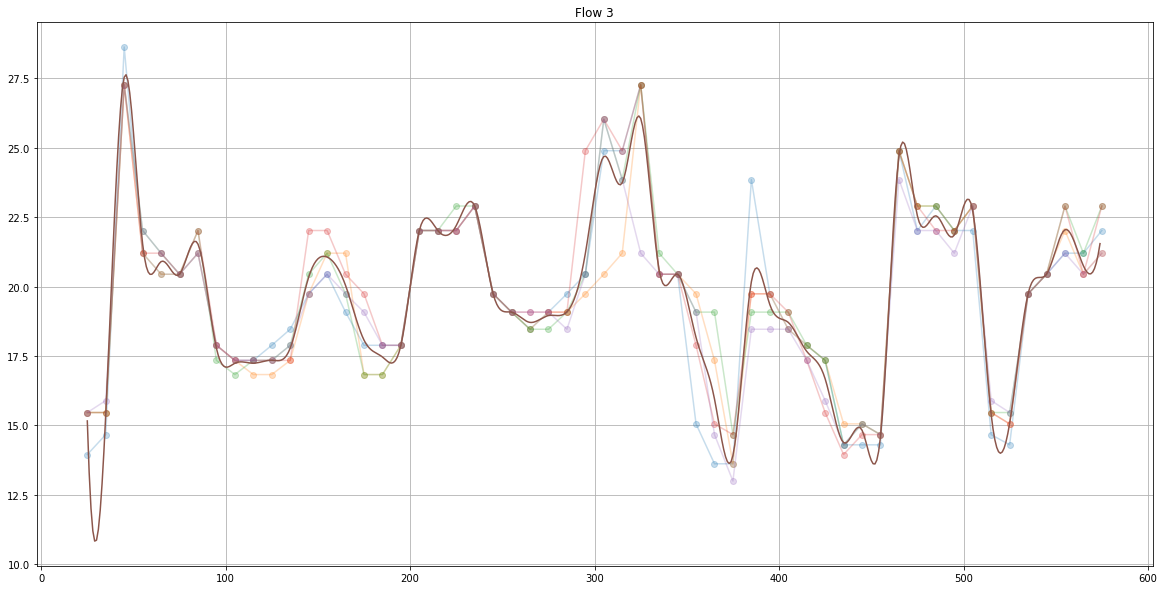

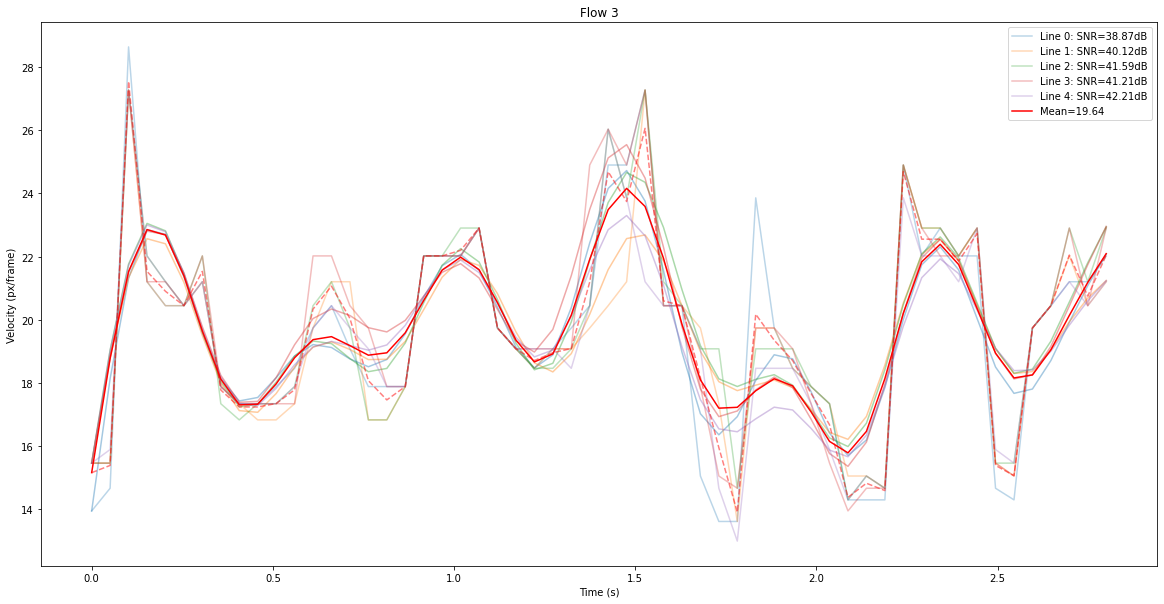

(5, 505, 2)


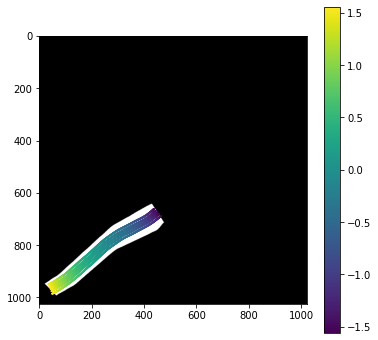

parallel line at -19

Location along the line :227/505; 500/600

parallel line at -9

Location along the line :227/505; 500/600

parallel line at 0

Location along the line :227/505; 500/600

parallel line at 9

Location along the line :227/505; 500/600

parallel line at 19

Location along the line :227/505; 500/600

(5, 1, 56)


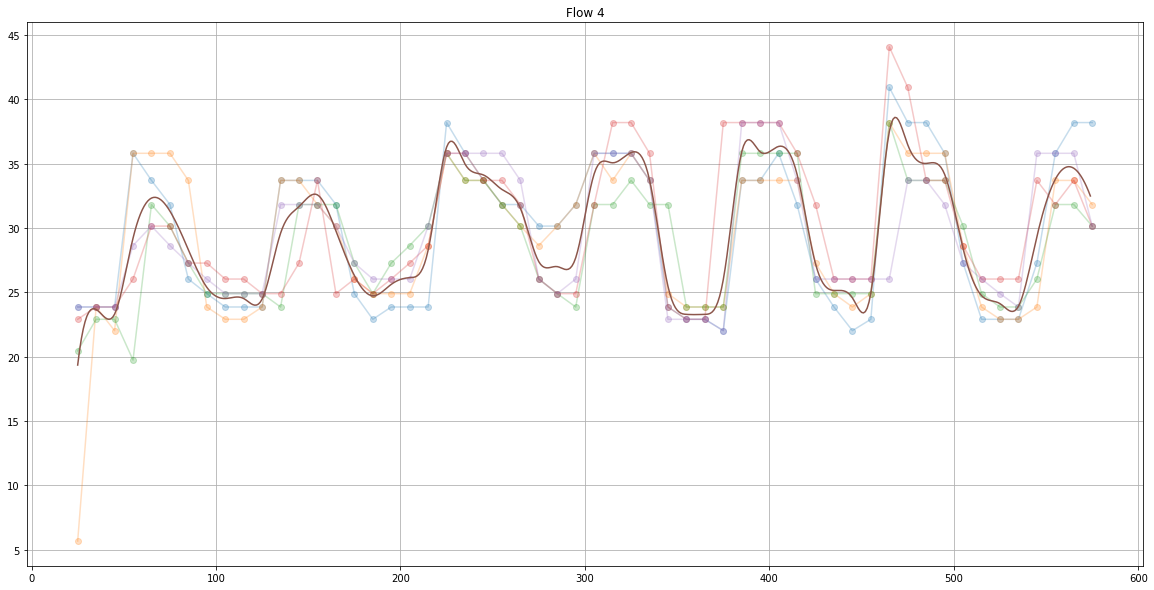

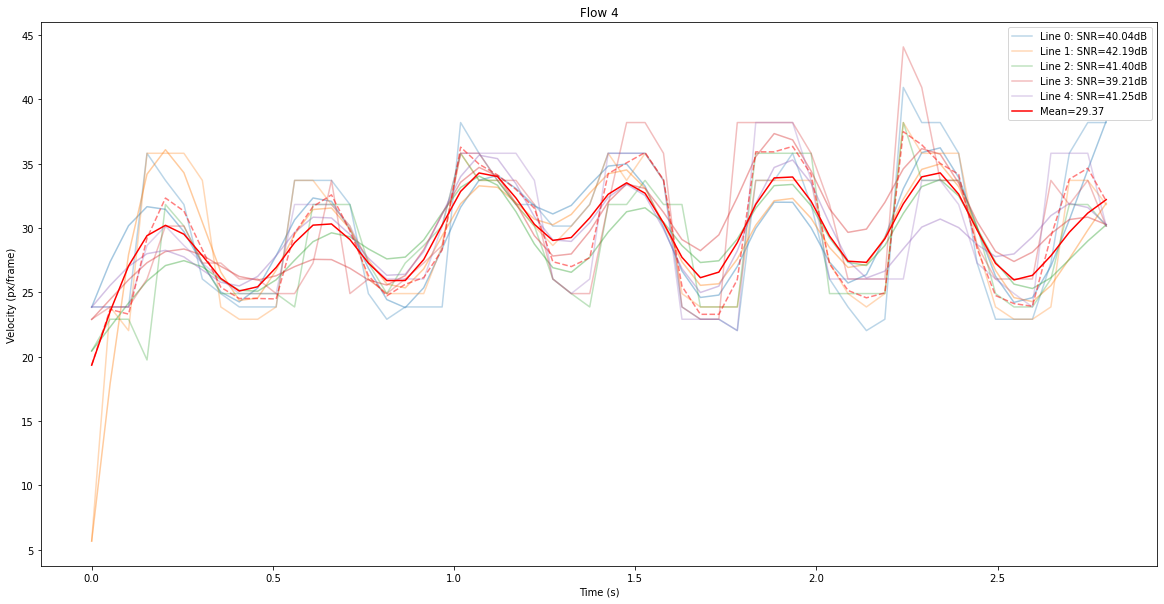

In [5]:
from velocity_utils import *

time_window, time_step = 50, 10
dist_setting = [280, None]
spacings_v = [5, 4, 3, 1, 9]

vs_profile_obj, flow_dict_obj = {}, {}

for vi in dir_dict.keys():
    spc = spacings_v[vi]
    spacings = [-2*spc-1, -spc, 0 , spc, 2*spc+1]
    dir_set = dir_dict[vi]
    # get more lines parallel to the centerline
    CL, vessel_walls, seg_mask = dir_set['CL'].copy(), dir_set['vessel_walls'].copy(), dir_set['seg_mask'].copy()

    # extract velocity
    dist_window, dist_step = int(len(CL) * 0.9), None
    if dist_step is None:
        dist_step = len(CL)
    vs_cls = []

    norms = get_normal_direction(CL, time_window=5)
    para_lines = get_parallel_lines(CL, norms, spacings)
    print(para_lines.shape)
    # display #1
    if True:
        plt.figure(figsize = (6,6))
        plt.imshow(seg_mask, cmap='gray')
        x = np.linspace(-1, 1, para_lines.shape[1])
        c = np.tan(x)
        for line in para_lines:
            plt.scatter(line[:,0], line[:,1], c = c, s=1)
        plt.colorbar()
        plt.show()

    for spacing, line in zip(spacings, para_lines):
        print(f'parallel line at {spacing}\n')
        line_profile = np.array([map_coordinates(frm,line[:,::-1].T, order=1) for frm in video[:]])
        r = compenstate_kymograph(line_profile)
        vs_spacing = kymograph_radon_transform(r[:,:], (80., 90.), time_window, time_step, dist_window, dist_step)
        vs_cls.append(np.array(vs_spacing))
        print('\n')
    vs_cls = np.array(vs_cls)
    print(vs_cls.shape)
    # temporal interpolate
    (times_interp, vs_interp), (tf, vs, vf) = velocity_profile_analysis(vs_cls, time_window, time_step, f'Flow {vi}')

    vs_profile_obj[vi] = {'ts': times_interp, 'vs': vs_interp, 'tf': tf, 'vsf': vs, 'vf': vf} 

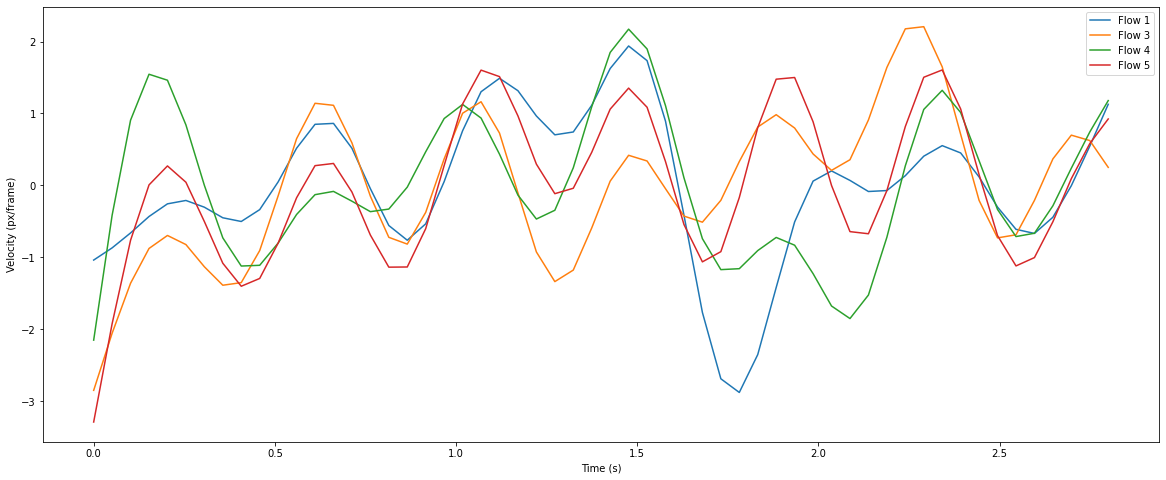

In [10]:
plt.figure(figsize=(20,8))
for vi in vs_profile_obj.keys():
    if vi == 1: continue
    # ts, vs = vs_profile_obj[vi]['ts'], vs_profile_obj[vi]['vs']
    ts, vs = vs_profile_obj[vi]['tf'], vs_profile_obj[vi]['vf']
    vs -= np.mean(vs)
    vs /= np.std(vs)
    plt.plot(ts, vs, label=f'Flow {vi+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (px/frame)')
plt.show()

In [ ]:
# remove black border
def detect_border(vid):
    border = np.min(vid, axis=0)
    x = np.max(border, axis=0)
    xs = np.argwhere(x > 0).min(), np.argwhere(x > 0).max()
    y = np.max(border, axis=1)
    ys = np.argwhere(y > 0).min(), np.argwhere(y > 0).max()
    return xs, ys

# smooth the mask contour
def smooth_contour(mask, n=3, disk_size=5, epsilon=0.002):
    for i in range(n):
        mask = morphology.erosion(mask, morphology.disk(disk_size))
    for i in range(n):
        mask = morphology.dilation(mask, morphology.disk(disk_size))
    # Assuming you have a binary mask image called 'mask'
    # Convert the mask to a binary image
    binary_mask = np.uint8(mask)
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Approximate the contours with a smoother curve
    # Create a blank image to draw the smoothed contour
    smoothed_contour_image = np.zeros_like(binary_mask)
    smoothed_contours =[]
    for i, contour in enumerate(contours):
        epsilon = epsilon * cv2.arcLength(contour, True)
        smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)  
        smoothed_contours.append(smoothed_contour)
    # Draw the smoothed contour on the image
    cv2.drawContours(smoothed_contour_image, smoothed_contours, -1, 1, thickness=cv2.FILLED)
        
    # Convert the smoothed contour image back to a binary mask
    mask = np.uint8(smoothed_contour_image)   
    return mask
def unique_pts(pts):
    unique_pts = []
    for pt in pts:
        pt = list(pt)
        if pt not in unique_pts:
            unique_pts.append(pt)
    return np.array(unique_pts)
def sort_pts(pts, start='u'):
    sorted_pts = []
    pts = unique_pts(pts)
    # u: up; d: down; l: left; r: right
    if 'u' in start:
        pts = pts[np.argsort(pts[:, 0])]
    elif 'd' in start:
        pts = pts[np.argsort(-pts[:, 0])]
    elif 'l' in start:
        pts = pts[np.argsort(pts[:, 1])]
    elif 'r' in start:
        pts = pts[np.argsort(-pts[:, 1])]
    while len(pts) > 0:
        if len(sorted_pts) == 0:
            sorted_pts.append(pts[0])
            pts = np.delete(pts, 0, axis=0)
        else:
            last_pt = sorted_pts[-1]
            #print(last_pt, pts.shape)
            dists = cal_dist(last_pt, pts)
            next_pt = pts[np.argmin(dists)]
            inv_dists = cal_dist(next_pt, np.array(sorted_pts))
            if np.min(dists) <= 10*np.min(inv_dists):
                sorted_pts.append(next_pt)
            pts = np.delete(pts, np.argmin(dists), axis=0)
    return np.array(sorted_pts)
def cal_dist(pt, curve):
    return np.sqrt((curve[:, 0]-pt[0])**2 + (curve[:, 1]-pt[1])**2)
def resample_even_pts(centerline_coords, spacing=1.):
    centerline_coords = unique_pts(centerline_coords).astype(np.float32)
    length = np.cumsum(np.sqrt(np.sum(np.diff(centerline_coords, axis=0)**2, axis=1)))
    length = np.insert(length, 0, 0)    
    f = interp1d(length, centerline_coords, kind='cubic', axis=0, fill_value='extrapolate')
    dists_new = np.linspace(0, max(length),int(np.round(max(length)/spacing))+1) #np.arange(0, max(length), spacing)
    centerline_coords_new = f(dists_new)
    return centerline_coords_new
def smooth_curves(points):
    distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    distance = np.insert(distance, 0, 0)/distance[-1]
    # # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=4, s=6) for coords in points.T]
    points_fitted = np.vstack([spl(distance) for spl in splines]).T
    # plt.plot(points[:,0], points[:,1], 'o', label='original points')
    # plt.plot(points_fitted[:,0], points_fitted[:,1], 'r', label='fitted spline')
    # plt.show()
    return points_fitted
def get_direction(clp, wind_size=5):
    directions = []
    for j in range(wind_size, clp.shape[0]-wind_size, 1):
        vx = clp[j+ wind_size, 0] - clp[j- wind_size, 0]
        vy = clp[j+ wind_size, 1] - clp[j- wind_size, 1]
        vec = np.array([vx, vy, 0])
        vec = vec/(np.linalg.norm(vec)+1e-6)
        directions.append(vec)
    return directions

def get_perpendicular_lines(clp, wind_size=5, dl = 5.5, step=1):
    Css, Dss = [], []
    for j in range(wind_size, clp.shape[0]-wind_size, 1):
        vx = clp[j+ wind_size, 0] - clp[j- wind_size, 0]
        vy = clp[j+ wind_size, 1] - clp[j- wind_size, 1]
        Cs, Ds = [], []
        for dd in range(step,int(dl), step):
            (Cx, Cy, Dx, Dy) = perpendicluar(clp[j][0], clp[j][1], vx,vy, dd)
            Cs.append((Cx, Cy))
            Ds.append((Dx, Dy))
        Css.append(np.array(Cs))
        Dss.append(np.array(Ds))
    Css = np.array(Css)[:,::-1]
    Dss = np.array(Dss)
    centerlines = np.concatenate([Css, clp[wind_size:-wind_size, None], Dss], axis=1)
    # plt.figure()
    # for i in range(centerlines.shape[1]):
    #     plt.plot(centerlines[:, i, 0], centerlines[:, i, 1], 'r', alpha = 0.1*i)
    # plt.show()
    return centerlines
def perpendicluar(x, y, vx, vy, d):
    mag = math.sqrt(vx * vx + vy * vy)
    vx, vy = -vy / mag, vx / mag
    Cx = (x + vx * d)
    Cy = (y + vy * d)
    Dx = (x - vx * d)
    Dy = (y - vy * d)
    return (Cx,Cy,Dx,Dy)

In [111]:
vid_path = '/Users/huangluojie/Desktop/Lip/Red0006 24-05-21 15-03-18.avi'
vid = imageio.get_reader(vid_path)
vid = np.array([frame[:,:,0] for i, frame in enumerate(vid) if i>11500 and i <= 13500]).astype(np.float32)
print(vid.shape)

FileNotFoundError: No such file: '/Users/huangluojie/Desktop/Lip/Red0006 24-05-21 15-03-18.avi'

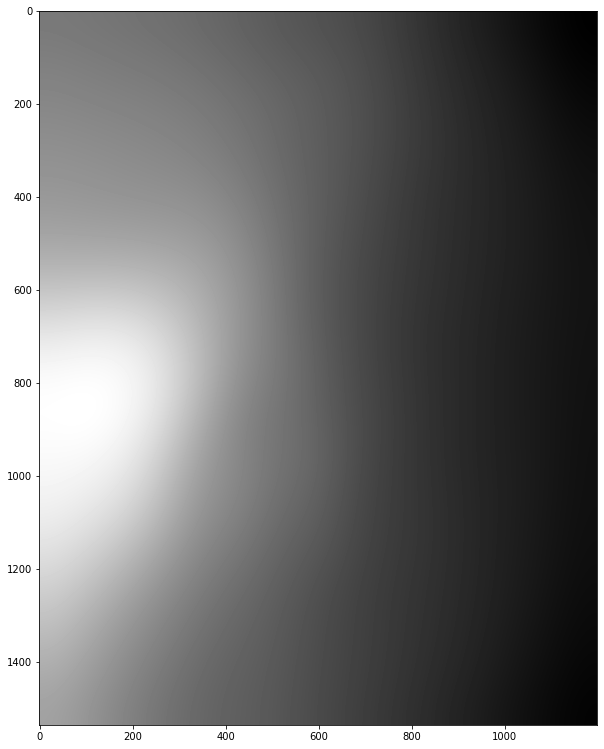

In [ ]:
# get background
bg = np.max(vid[::5], axis=0)
bg = gaussian_filter(bg, 60)
plt.figure(figsize=(10, 15))
plt.imshow(bg, cmap='gray')
plt.show()

In [ ]:
vid_corrected = vid[:] / bg
vid_corrected -= np.min(vid_corrected)
vid_corrected /= np.max(vid_corrected)
vid_corrected = (vid_corrected * 255).astype(np.uint8)
# save as .tiff
tifffile.imsave('/Users/huangluojie/Desktop/Lip/Red0006_24-05-21_15-03-18_corrected_4000.tiff', vid_corrected)

In [ ]:
vid_path = '/Users/huangluojie/Desktop/Lip/Green0006_24-05-21_15-03-17_corrected_stable.tif'
# vid_path = '/Users/huangluojie/Desktop/Cytometry/MGH_Data/20230418_P07_V03_01_FastStackReg_2307140219/20230418_P07_V03_01_3.65pxum_FastRegXYZIntEq.tif'
# Load the video
vid = tifffile.imread(vid_path)
border = detect_border(vid)
vid = vid[:, border[1][0]:border[1][1], border[0][0]:border[0][1]]
# CLAHE to enhance the contrast
# clahe = cv2.createCLAHE(clipLimit =4., tileGridSize=(30,30))
vid_enhanced = vid.copy().astype(np.float32) # np.array(vid_enhanced).astype(np.float32) # 
# vid_enhanced = exposure.equalize_adapthist(vid[:], clip_limit=0.05, kernel_size=15) # vid.copy()
print(vid_enhanced.shape)
vid_flow = np.std(vid[::5], axis=0) #  vid_flow = np.max(vid, axis=0) - np.mean(vid, axis=0) # 

# load ground truth from .csv file
vid_name = os.path.basename(vid_path).split('.')[0]
vid_name = '_'.join(vid_name.split('_')[1:])
print(vid_name)
# df = pd.read_csv('/Users/huangluojie/Desktop/Cytometry/MGH_Data/20231211/20231211_ManualCellCt.csv')
# GT = df[f'{vid_name}; Frame'].values
# # reomve NaN
# GT = GT[~np.isnan(GT)]-1 #np.unique(GT[~np.isnan(GT)])-1
# print('WBC count:', len(GT))

(6000, 748, 538)
24-05-21_15-03-17_corrected_stable


In [ ]:
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
# optical flow colormap
angles = np.linspace(0, 2*np.pi, 360)
ls = np.linspace(0, 1, 41)[::-1]
plt.figure(figsize=(5,5))
for a in angles:
    for l in ls:
        vec = np.array([np.cos(a), np.sin(a)])*l
        ccode = np.array((vec[0]/2+0.5, vec[1]/2+0.5, 0))*(l+2.)/3.
        plt.plot([0, vec[0]], [0, vec[1]], c=ccode)
plt.show()

mask_path = '/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/vessel_mask/P01_V03_03.png'
masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
flow_speed = [0.7, 0.4]
bg_speed = 0.25
bg_dir = [4, 1]
bg_vec = (bg_dir/np.linalg.norm(bg_dir)*bg_speed).tolist()+[0]
print(bg_vec)

plt.figure(figsize=(20, 10))
plt.imshow(masks, cmap='gray')
plt.show()

flowmap = np.ones((masks.shape[0], masks.shape[1], 3)) * bg_vec
plt.figure(figsize=(20, 10))
plt.imshow(flowmap.transpose(1,0,2))
frpts, pixvalues = [], []
for mi in range(1, np.max(masks)+1):
    mask = np.zeros_like(masks) 
    mask[masks==mi] = 1
    centerline = morphology.skeletonize(mask)
    sort_mode = 'l'
    centerline_coords = sort_pts(np.argwhere(centerline), sort_mode)
    centerline_coords_list = get_perpendicular_lines(centerline_coords, wind_size=6, dl =40, step=2)
    points, vals = [], []
    for ci  in range(centerline_coords_list.shape[1]): 
        centerline = centerline_coords_list[:, ci, :]
        centerline = sort_pts(centerline[::8])
        centerline = resample_even_pts(centerline, spacing=1)
        centerline_vec = get_direction(centerline, wind_size=8)
        centerline = centerline[8:-8]
        centerline_vec = np.array([(vec/2+.5)*flow_speed[mi-1]+bg_vec for vec in centerline_vec])
        # isfg = map_coordinates(mask, centerline.T, order=3, mode='grid-wrap')
        # idx = np.argwhere(isfg==1)[:,0]
        idx = np.arange(centerline.shape[0])
        plt.scatter(centerline[idx, 1], centerline[idx, 0], c=centerline_vec[idx])
        points.append(centerline[idx])
        vals.append(centerline_vec[idx])
    points, vals = np.concatenate(points), np.concatenate(vals)
    frpt  = np.array(np.where(masks==mi)).T
    pixvalue = griddata(points[:,], vals[:,:], frpt, method='nearest')
    frpts.append(frpt)
    pixvalues.append(pixvalue)
plt.show()

frpts, pixvalues = np.concatenate(frpts), np.concatenate(pixvalues)
plt.figure(figsize=(20, 10))
plt.imshow(flowmap.transpose(1,0,2))
plt.scatter(frpts[:,1], frpts[:, 0], c=pixvalues)
plt.show()


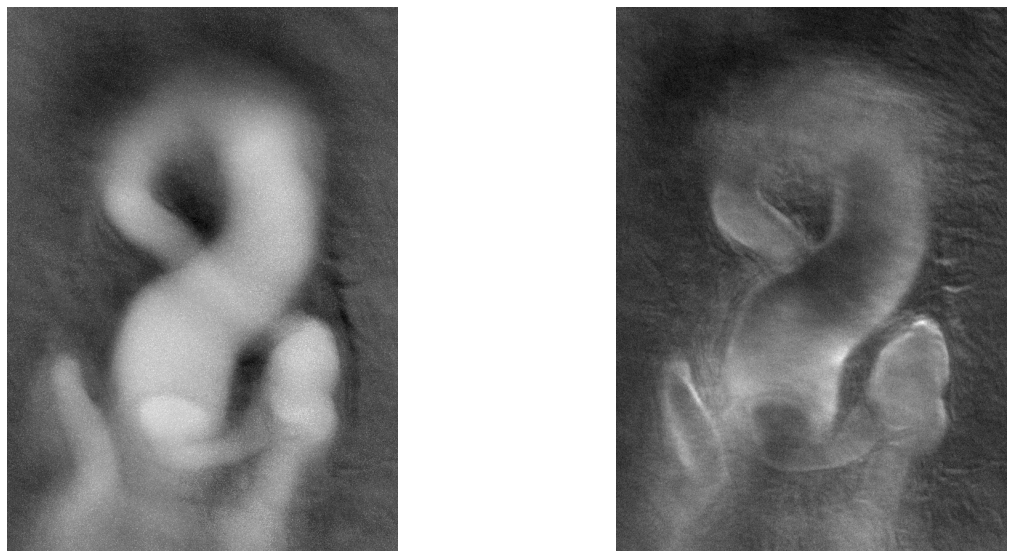

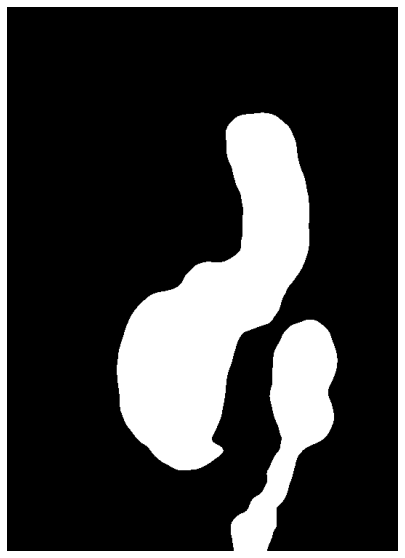

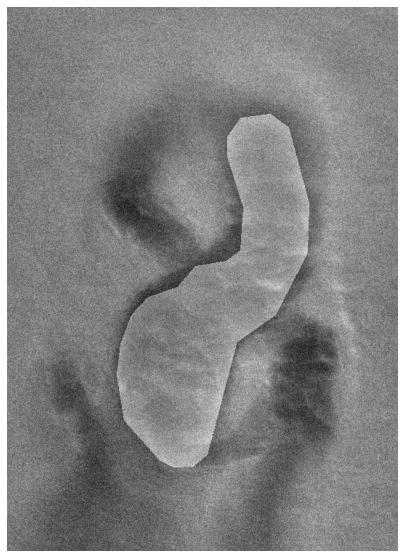

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


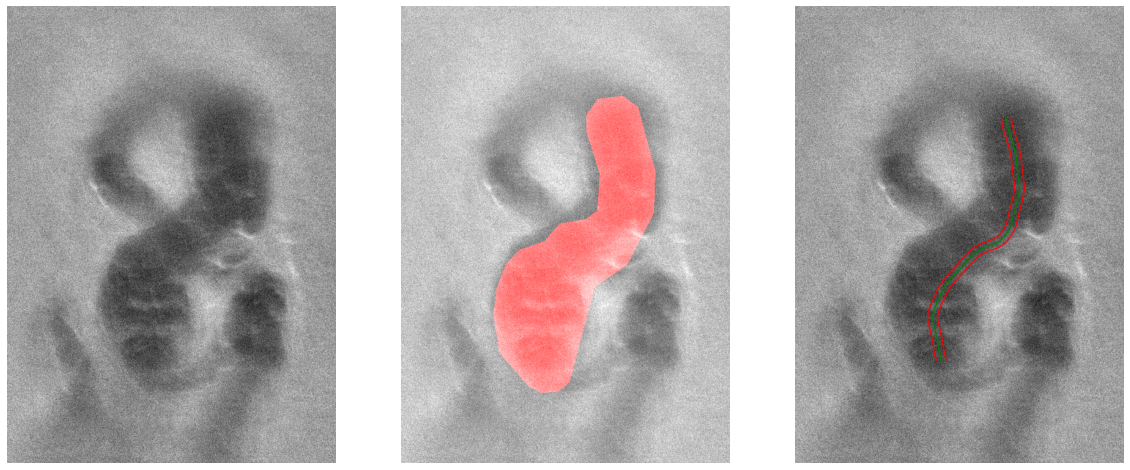

In [ ]:
vid_min = np.min(vid[::5], axis=0).astype(np.float32)
vid_min -= np.min(vid_min)
vid_min /= np.max(vid_min)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(1-vid_min, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((vid_flow), cmap='gray')
plt.axis('off')
plt.show()

from PIL import Image, ImageFilter
# turn into binary mask with threshold
mask = (vid_flow/(vid_min+1e-4)).astype(np.float32).copy()
mask = gaussian_filter(mask, sigma=5.)
# mask -= np.min(mask)
# mask /= np.max(mask)

# # edge detection
# contours, _ = cv2.findContours((mask*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# plt.figure(figsize=(20, 10))
# plt.imshow(contours, cmap='gray')
# plt.axis('off')
# plt.show()

mask = mask > (np.mean(mask) + .35 * np.std(mask))
mask = morphology.area_opening(mask, area_threshold=15000)
# mask = morphology.binary_closing(mask, morphology.disk(10))
mask = morphology.remove_small_holes(mask, area_threshold=8000)
# mask1 = mask[:250].copy()
# mask2 = mask[250:].copy()
# mask1 = mask1 > (np.mean(mask1) + .2 * np.std(mask1))
# mask1 = morphology.remove_small_objects(mask1, min_size=1000)
# mask1 = morphology.binary_closing(mask1, morphology.disk(5))

# mask2 = mask2 > (np.mean(mask2) + 1.8 * np.std(mask2))
# mask2 = morphology.remove_small_objects(mask2, min_size=1000)

# mask = np.concatenate([mask1, mask2], axis=0)
# mask = np.array(Image.fromarray(mask).filter(ImageFilter.ModeFilter(size=5)))
plt.figure(figsize=(20, 10))
plt.imshow(mask[:,:], cmap='gray')
plt.axis('off')
plt.show()

# # close holes & remove small objects
mask = morphology.binary_opening(mask, morphology.disk(40))
mask = morphology.erosion(mask, morphology.disk(3))
mask = morphology.remove_small_objects(mask, min_size=10000)
mask = morphology.dilation(mask, morphology.disk(3))
mask = morphology.binary_closing(mask, morphology.disk(5))
# mask = morphology.dilation(mask, morphology.disk(5))
# mask = morphology.binary_closing(mask, morphology.disk(2))
# mask = morphology.erosion(mask, morphology.disk(5))
mask = smooth_contour(mask, n=2, disk_size=3, epsilon=1e-5)
mask = morphology.remove_small_objects(mask.astype('bool'), min_size=40000)
# # count the number of objects
mask = morphology.label(mask)

plt.figure(figsize=(20, 10))
plt.imshow(mask/4.+vid[1000]/255., cmap='gray')
plt.axis('off')
plt.show()

# # save the mask
# mask = mask.astype(np.uint8)
# mask_path = f'/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/vessel_mask/{vid_name}.png'
# cv2.imwrite(mask_path, mask)


# skeletonization
centerline = morphology.skeletonize(mask)
sort_mode = 'u'
# extract the centerline coordinates in order
centerline_coords = sort_pts(np.argwhere(centerline), sort_mode)[:]
sort_mode = 'u'
centerline_coords = sort_pts(centerline_coords, sort_mode)
centerline_coords = smooth_curves(resample_even_pts(centerline_coords, spacing=5.))
centerline_coords = resample_even_pts(centerline_coords, spacing=1.)
centerline_coords_list = get_perpendicular_lines(centerline_coords, wind_size=4, dl = 12, step=8)
para_centerline_coords = []
for ci  in range(centerline_coords_list.shape[1]):
    pts =  np.unique(centerline_coords_list[:, ci], axis=0).astype(np.float32)
    pts = sort_pts(pts, sort_mode)
    pts_even = resample_even_pts(pts, spacing=1.)
    para_centerline_coords.append(pts_even)

# overlay the mask on the original image
plt.figure(figsize=(20, 10))
disp = np.zeros((vid_flow.shape[0], vid_flow.shape[1], 3))
disp[:,:,0] = 0.005*vid_enhanced[100].astype(np.float32) + mask.astype(np.float32)
disp[:,:,1] = 0.005*vid_enhanced[100].astype(np.float32)
disp[:,:,2] = 0.005*vid_enhanced[100].astype(np.float32) #+ centerline.astype(np.float32)
plt.subplot(1, 3, 1)
plt.imshow(vid[100], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(disp, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(vid[100], cmap='gray')
for ci in range(len(para_centerline_coords)):
    col = 'r' if (ci % 2 == 0) else 'g'
    plt.plot(para_centerline_coords[ci][:,1], para_centerline_coords[ci][:,0], col, alpha=0.8)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


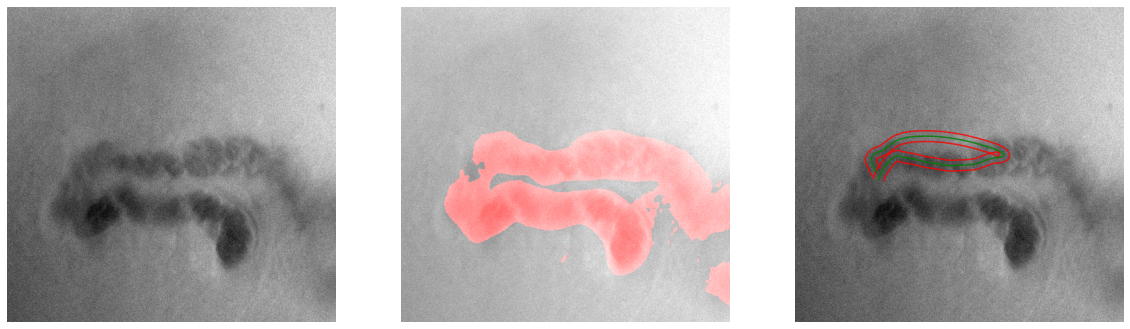

In [ ]:

# skeletonization
centerline = morphology.skeletonize(mask)
sort_mode = 'u'
# extract the centerline coordinates in order
centerline_coords = sort_pts(np.argwhere(centerline), sort_mode)[100:350]
sort_mode = 'd'
centerline_coords = sort_pts(centerline_coords, sort_mode)
centerline_coords = smooth_curves(resample_even_pts(centerline_coords, spacing=5.))
centerline_coords = resample_even_pts(centerline_coords, spacing=1.)
centerline_coords_list = get_perpendicular_lines(centerline_coords, wind_size=4, dl = 12, step=8)
para_centerline_coords = []
for ci  in range(centerline_coords_list.shape[1]):
    pts =  np.unique(centerline_coords_list[:, ci], axis=0).astype(np.float32)
    pts = sort_pts(pts, sort_mode)
    pts_even = resample_even_pts(pts, spacing=1.)
    para_centerline_coords.append(pts_even)

# overlay the mask on the original image
plt.figure(figsize=(20, 10))
disp = np.zeros((vid_flow.shape[0], vid_flow.shape[1], 3))
disp[:,:,0] = 0.005*vid_enhanced[100].astype(np.float32) + mask.astype(np.float32)
disp[:,:,1] = 0.005*vid_enhanced[100].astype(np.float32) 
disp[:,:,2] = 0.005*vid_enhanced[100].astype(np.float32) #+ centerline.astype(np.float32)
plt.subplot(1, 3, 1)
plt.imshow(vid[100], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(disp, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(vid[100], cmap='gray')
for ci in range(len(para_centerline_coords)):
    col = 'r' if (ci % 2 == 0) else 'g'
    plt.plot(para_centerline_coords[ci][:,1], para_centerline_coords[ci][:,0], col, alpha=0.8)
plt.axis('off')
plt.show()

## 2 Get Channel Size

In [33]:
from scipy.spatial.distance import cdist
def get_width_lines(clp, mask, wind_size=5):
    rough_w = np.sum(mask)/len(clp)/2
    ## channel edge
    edge = mask.copy().astype(np.int16)
    edge = edge - morphology.binary_erosion(edge, morphology.disk(1))
    # dists = distance_transform_edt(1-edge) * mask
    # mean_dist = np.mean(dists[dists>0])
    # print(rough_w, mean_dist)

    bg = mask.astype(np.int16)
    bg = (1 - bg).astype(bool)
    
    Css, Dss, dias = [], [], []
    for j in range(wind_size, clp.shape[0]-wind_size, 1):
        print('{}/{}'.format(j, clp.shape[0]), end='\r')
        vx = clp[j+ wind_size, 0] - clp[j- wind_size, 0]
        vy = clp[j+ wind_size, 1] - clp[j- wind_size, 1]
        Cs, Ds = [], []
        dd=0
        Mc, Md =False, False
        while not (Mc and Md):
            dd += 1
            (Cx, Cy, Dx, Dy) = perpendicluar(clp[j][0], clp[j][1], vx,vy, dd)
            Mc, Md = bg[int(np.round(Cx)), int(np.round(Cy))], bg[int(np.round(Dx)),int(np.round(Dy))]
            if not Mc:  Cs=np.array((Cx, Cy))
            if not Md:  Ds=np.array((Dx, Dy))
        dias.append((np.sqrt(np.sum((Cs-clp[j])**2)), np.sqrt(np.sum((Ds-clp[j])**2))))
        Css.append(Cs)
        Dss.append(Ds)
    return np.array(Css), np.array(Dss), clp[wind_size:-wind_size], np.array(dias)
# detect connected lines
def Chaining(coords_list, start_idx, dist_thrsh=3):
    chains = []
    dist_matrx = cdist(coords_list, coords_list)
    unvisited_idx = np.arange(len(coords_list))
    current_idx = start_idx 
    while len(unvisited_idx) > 0:
        unvisited_idx = unvisited_idx[unvisited_idx != current_idx]
        chain_idx = [current_idx]
        dists = dist_matrx[np.array(chain_idx),:] [:, unvisited_idx]
        while dists.shape[1]>0 and np.min(dists) < dist_thrsh:
            shortest_chain, shortest_idx = np.unravel_index(np.argmin(dists), dists.shape)
            if shortest_chain == 0:
                chain_idx.insert(0, unvisited_idx[shortest_idx])
            else: #if shortest_chain >= len(chain_idx) - 2:
                chain_idx.append(unvisited_idx[shortest_idx])
            unvisited_idx = np.delete(unvisited_idx, shortest_idx)
            dists = dist_matrx[np.array(chain_idx),:][:,unvisited_idx]
            # print(dists.shape, len(unvisited_idx))
        if len(chain_idx) > 1:
            chains.append(coords_list[chain_idx])
        if len(unvisited_idx) > 0:  current_idx = unvisited_idx[0]
    lengths = [len(c) for c in chains]
    chains = [chains[id] for id in np.argsort(lengths)[::-1]]
    return chains
# width estimation
def get_width(clp, mask, wind_size=3, dist_thrsh=20, sort_mode='u'):
    Css_ori, Dss_ori, clp, Dias = get_width_lines(clp, mask, wind_size)
    Dss = Chaining(Dss_ori[0::3], 0, dist_thrsh=dist_thrsh)[0]
    Css = Chaining(Css_ori[0::3], 0, dist_thrsh=dist_thrsh)[0]
    Css, Dss = sort_pts(Css, sort_mode), sort_pts(Dss, sort_mode)
    Css, Dss = resample_even_pts(Css, spacing=1.), resample_even_pts(Dss, spacing=1.)
    sub_channel = np.zeros_like(mask).astype(np.uint8)
    contour = np.concatenate([Css, Dss[::-1]], axis=0)[:,None,::-1].astype(int)
    cv2.drawContours(sub_channel, [contour], -1, 1,thickness=cv2.FILLED)
    dia = np.sum(sub_channel)/(len(clp))
    return sub_channel, (Css_ori, Dss_ori, Css, Dss), clp, dia

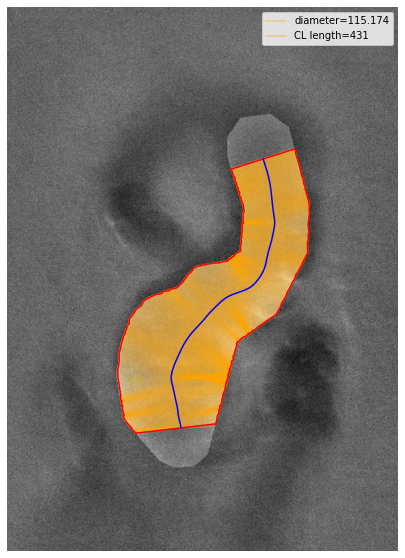

In [53]:
clp = centerline_coords.copy()[25:]
sub_channel, (Css_ori, Dss_ori, Css, Dss), clp, dia = get_width(clp, mask, 
                                                                wind_size=6, 
                                                                dist_thrsh=20, 
                                                                sort_mode=sort_mode)

vid_show = vid[100].copy().astype(np.float32)
vid_show -= np.min(vid_show)
vid_show /= np.max(vid_show)
plt.figure(figsize=(20, 10))
plt.imshow((sub_channel+mask)/3+vid_show, cmap='gray')
for c, d, in zip(Css_ori, Dss_ori):
    plt.plot((c[1], d[1]), (c[0], d[0]), 'orange', alpha=0.4)
plt.plot(Css[:,1], Css[:,0], 'r')
plt.plot(Dss[:,1], Dss[:,0], 'r')
plt.plot((Css[0,1], Dss[0,1]), (Css[0,0], Dss[0,0]), 'r')
plt.plot((Css[-1,1], Dss[-1,1]), (Css[-1,0], Dss[-1,0]), 'r')
plt.plot(clp[:,1], clp[:,0], c='b')
plt.axis('off')
plt.legend(['diameter={:.3f}'.format(dia), 'CL length={}'.format(len(clp))])
# plt.show()
# # save flow segmentation
# save_path = '/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/flow_mask/'
# save_path = os.path.join(save_path, vid_name+'.png')
# plt.savefig(save_path)


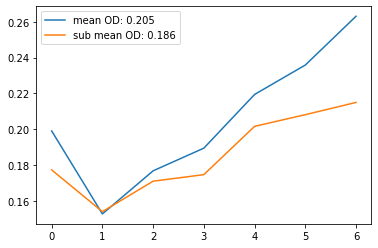

(7, 1103, 996, 3) (7, 1103, 996, 3)


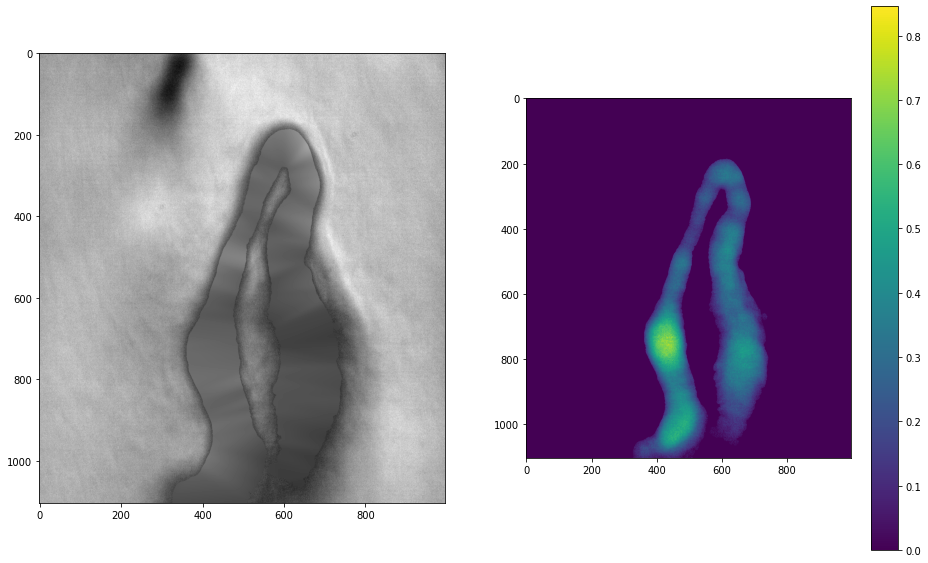

In [30]:
from skimage.restoration import inpaint
## optical density measurement
def get_adj_bg(mask, image, adj_dist = 10):
    image = image.copy()
    image_blurred = gaussian_filter(image, sigma=3)
    mask_bg = morphology.dilation(mask, morphology.disk(adj_dist)) #^ morphology.dilation(mask, morphology.disk(5))   

    points = np.where(1-mask_bg)
    values = image_blurred[points]
    grid_y, grid_x = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    from scipy.interpolate import griddata
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='linear')
    image_restored = gaussian_filter(grid_z0, sigma=5)
    # image_restored = cv2.inpaint(image_blurred.astype('uint8'), mask_bg.astype('uint8'), 15,cv2.INPAINT_TELEA)
    image_restored = image_restored*(mask) + image*(1-mask)
    return image_restored

#rolling average
ODs, fmeans = [], []
mean_ODs, sub_mean_ODs = [], []
step = 500
for i in range(0, len(vid)-step, step):
    print('{}/{}'.format(i, len(vid)), end='\r')
    frame_mean = np.mean(vid[i : i+step], axis=0).astype(np.float32)
    image_restored = get_adj_bg(mask, frame_mean, adj_dist = 10)
    OD = -np.log(frame_mean / image_restored)
    OD[OD<0.] = 0.
    mean_ODs.append(np.mean(OD[OD>0]))
    sub_OD = OD * sub_channel
    sub_mean_ODs.append(np.mean(sub_OD[sub_OD>0]))
    ODs.append(OD)
    fmeans.append(frame_mean)

plt.plot(mean_ODs, label='mean OD: {:.3f}'.format(np.mean(mean_ODs)))
plt.plot(sub_mean_ODs, label='sub mean OD: {:.3f}'.format(np.mean(sub_mean_ODs)))
plt.legend()
# plt.savefig('/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/ODs/'+vid_name+'.png')
plt.show()

# save ODs as .gif
ODs, fmeans = np.array(ODs), np.array(fmeans)
ODs = ((ODs - np.min(ODs))/(np.max(ODs) - np.min(ODs))*255).astype(np.uint8)
ODs = np.array([cv2.applyColorMap(od.astype(np.uint8), cv2.COLORMAP_HOT) for od in ODs])[:,:,:,::-1]

fmeans = (fmeans - np.min(fmeans))/(np.max(fmeans) - np.min(fmeans))
fmeans = (fmeans*255).astype(np.uint8)
frames_save = np.repeat(fmeans[:, :, :, None], 3, axis=3)
print(ODs.shape, frames_save.shape)

ODs_save = np.concatenate([frames_save, ODs], axis=2)
# imageio.mimsave('/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/ODs/'+vid_name+'.gif', ODs_save)

plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(image_restored, cmap='gray')
plt.subplot(122)
plt.imshow(OD)
plt.colorbar()
plt.show()

## 3. ST Processing & WBC Detection

### 3.1 Velocity estimation

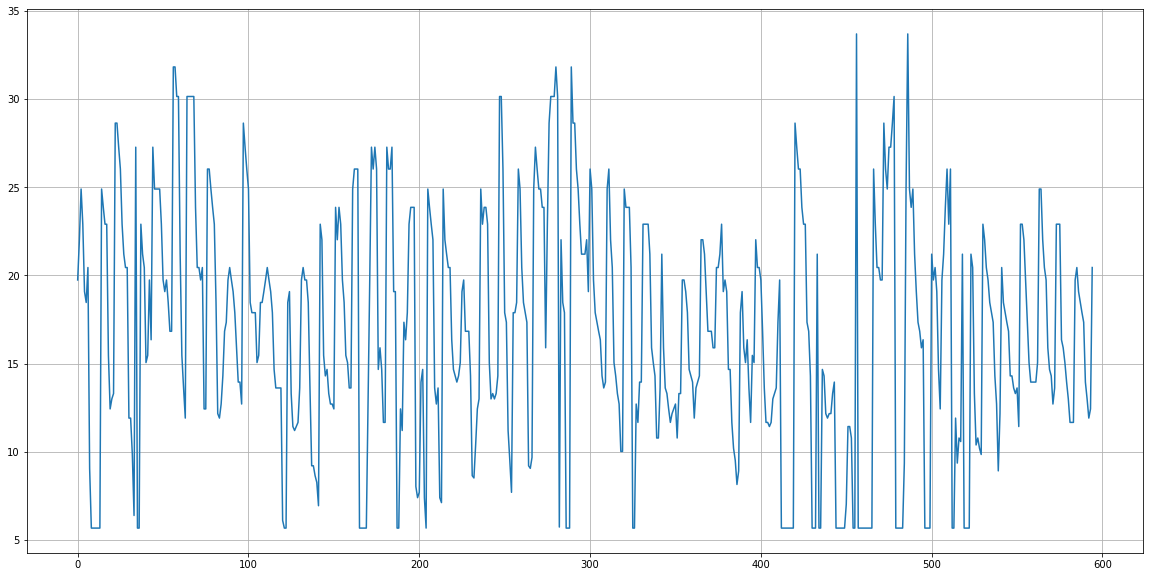

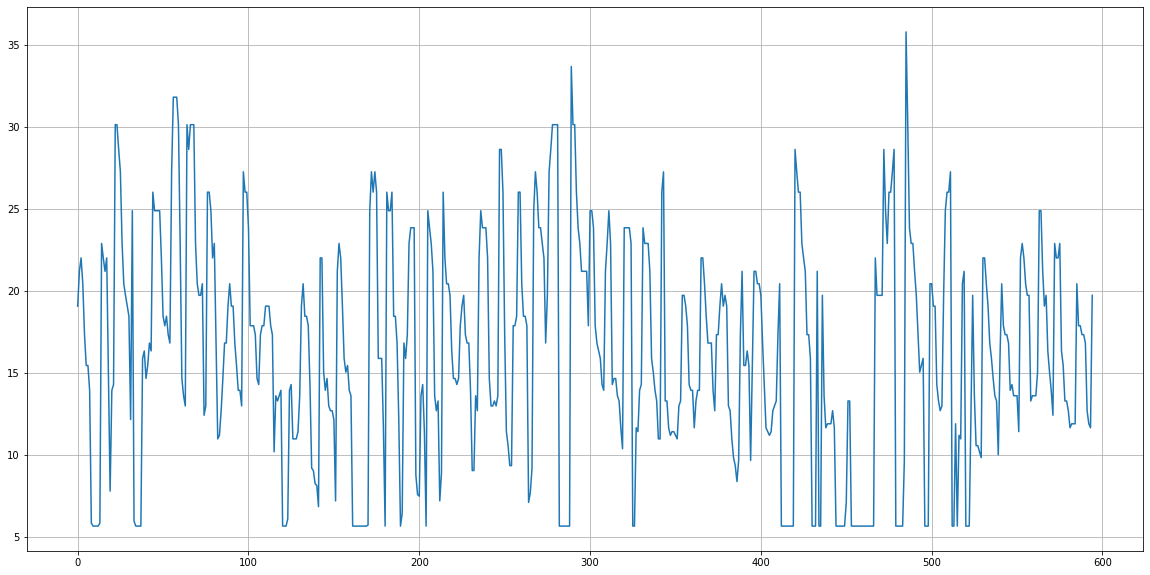

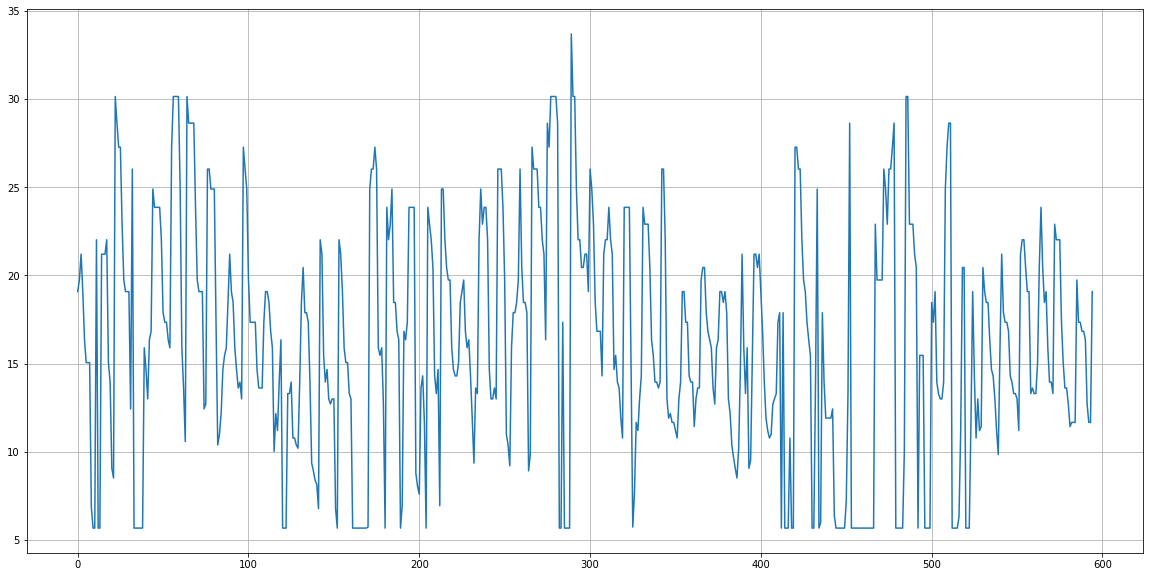

In [54]:
from scipy.ndimage import map_coordinates
from skimage.transform import radon
vs_cls = []

centerline_coords_list = get_perpendicular_lines(clp, wind_size=4, dl = 6, step=5)
para_centerline_coords = []
for ci  in range(centerline_coords_list.shape[1]):
    pts =  np.unique(centerline_coords_list[:, ci], axis=0).astype(np.float32)
    pts = sort_pts(pts, sort_mode)
    pts_even = resample_even_pts(pts, spacing=1.)
    # plt.figure(figsize=(20, 10))
    # plt.plot(pts[:,1], pts[:,0], 'r-', alpha=0.25)
    # plt.scatter(pts[::10,1], pts[::10,0], c='r', alpha=0.8)
    # plt.scatter(pts_even[:,1], pts_even[:,0], c='g', alpha=0.8)
    # plt.legend(['', 'original', 'resampled'])
    # plt.axis('off')
    # plt.show()
    para_centerline_coords.append(pts_even)

for i in range(len(para_centerline_coords)):
    vid_centerline = np.array([map_coordinates(frm,para_centerline_coords[i].T, order=1) for frm in vid_enhanced])
    Gt = np.mean(vid_centerline.astype(np.float32), axis=0, keepdims=True)
    Gd = np.mean(vid_centerline.astype(np.float32), axis=1, keepdims=True)
    G_bar = np.dot(Gd, Gt) / np.mean(vid_centerline.astype(np.float32))

    W = vid_centerline / (Gt/np.mean(vid_centerline.astype(np.float32)))
    W = W - np.mean(W)

    r = vid_centerline / G_bar
    r = r - np.mean(r)
    # r = r[:,::-1]
    '''
    plt.figure(figsize=(20, 15))
    plt.subplot(4, 1, 1)
    plt.title('Original')
    plt.imshow(vid_centerline[:2000].T, cmap='gray')
    plt.subplot(4, 1, 2)
    plt.title('Variations')
    plt.imshow(G_bar[:2000].T, cmap='gray')
    plt.subplot(4, 1, 3)
    plt.title('WBC signal')
    plt.imshow(W[:2000].T, cmap='gray')
    plt.subplot(4, 1, 4)
    plt.title('Residual of compensated signal')
    plt.imshow(r[:2000].T, cmap='gray')
    plt.show()
    '''
    ## radon transform
    theta = np.linspace(80., 90., (90-80)*10, endpoint=False)
    time_window = 50
    dist_window = 0
    vs =[]
    for t in range(0, vid_centerline.shape[0]-time_window, 10):
        if (t)%100 == 0: print('{}/{}'.format(t, vid_centerline.shape[0]), end='\r')
        seg = r[t: t+time_window,dist_window:-dist_window-1]
        sinogram = radon(seg, theta=theta, circle=False)
        '''
        # plt.figure(figsize=(20, 10))
        # plt.imshow(sinogram, cmap='hot', aspect='auto')
        # plt.xticks(np.linspace(0, len(theta), 11), np.linspace(theta[0], 105., 11))
        # plt.xlabel('Angle (degree)')
        # plt.ylabel('Distance (pixel)')
        # plt.colorbar()
        # plt.show()
        
        # plt.plot(np.std(sinogram, axis=0))
        # plt.xticks(np.linspace(0, len(theta), 11), np.linspace(theta[0], 105., 11))
        # plt.vlines(np.argmax(np.std(sinogram, axis=0)), 0, np.max(np.std(sinogram, axis=0)), 'r')
        # plt.text(np.argmax(np.std(sinogram, axis=0)), np.max(np.std(sinogram, axis=0)), 
        #          f'$\Theta$ = {theta[np.argmax(np.std(sinogram, axis=0))]}$^\circ$', 
        #          verticalalignment='center', horizontalalignment='left', fontsize=12)
        # plt.ylim(0)
        # plt.xlabel('Angle (degree)')
        # plt.ylabel('Std of sinogram')
        # plt.grid()
        # plt.show()
        '''
        deg = theta[np.argmax(np.std(sinogram, axis=0))]
        vel = np.tan(np.deg2rad(deg))
        vs.append(vel) 
    plt.figure(figsize=(20, 10))
    plt.plot(vs)
    plt.grid()
    plt.show()
    vs_cls.append(vs)

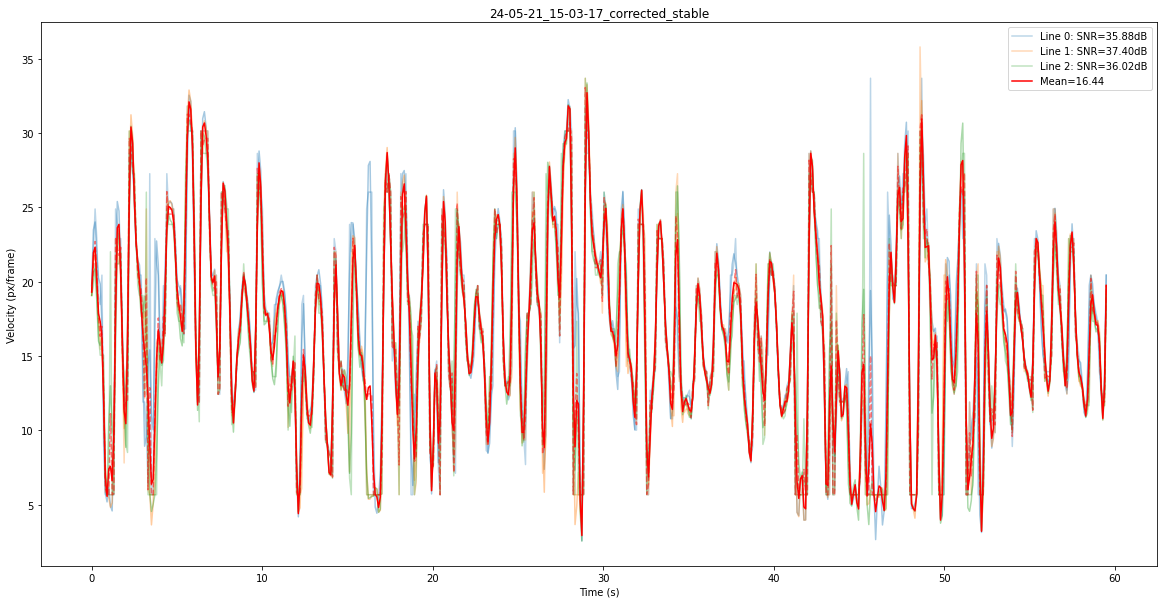

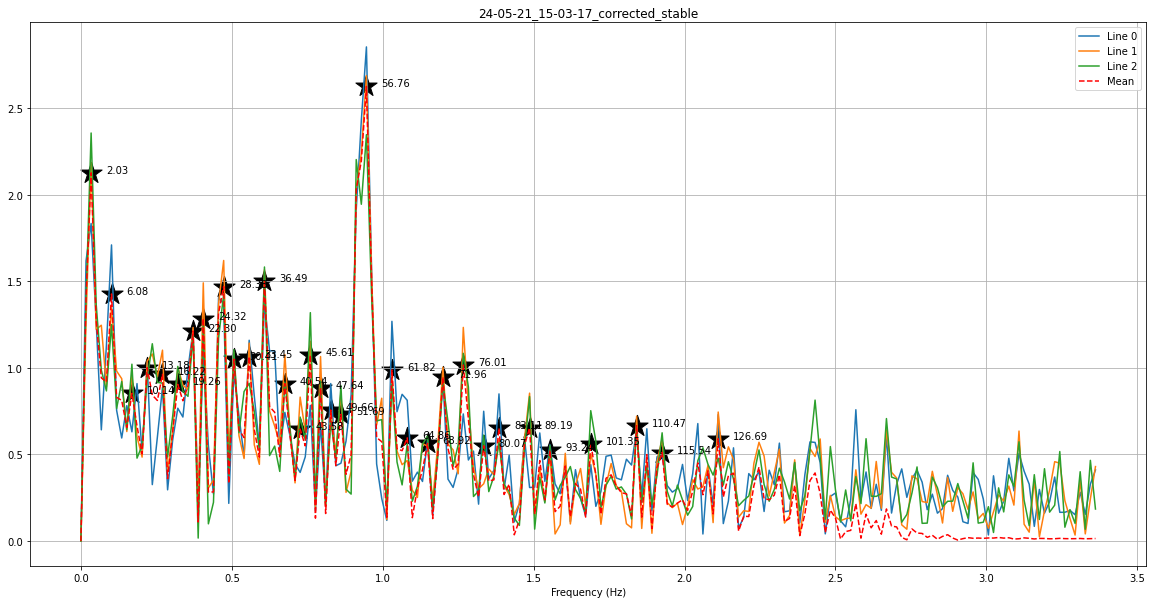

In [55]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Get the filter coefficients 
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
minlen =int(np.min([len(vs) for vs in vs_cls]))
cutoff, fs = 2.5, 10.
times = np.linspace(0, minlen/fs, minlen)
# vs_ind0 = vs.copy()
plt.figure(figsize=(20, 10))
plt.title(vid_name)
vss, vfs = [], []
for lind, vs in enumerate(vs_cls[:]):
    vs = vs[:minlen].copy()
    vs_filtered = butter_lowpass_filter(vs, cutoff, fs, order=5)
    vss.append(vs)
    vfs.append(vs_filtered)
    # Calculate the SNR
    SNR = 20 * np.log10(np.mean(vs_filtered**2) / np.mean((vs -vs_filtered)**2))
    p = plt.plot(times, vs, alpha=0.3, label=f'Line {lind}: SNR={SNR:.2f}dB')
    color = p[0].get_color()
    plt.plot(times, vs_filtered, c=color, alpha=0.4)
# plt.plot(times, vs_filtered_ind0, 'green')
vs, vf = np.mean(np.array(vss), axis=0), np.mean(np.array(vfs), axis=0)
plt.plot(times, vs, 'r--', alpha=0.5)
plt.plot(times, vf, 'r', label=f'Mean={np.mean(vf):.2f}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (px/frame)')
# save velocity plot
save_path = '/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/velocity'
save_path = os.path.join(save_path, vid_name+'_velocity.png')
# plt.savefig(save_path)
plt.show()

# plot frequency specturm of vs_filtered
# '''
from scipy.fftpack import fft
plt.figure(figsize=(20, 10))
plt.title(vid_name)
for lind, vs in enumerate(vs_cls):
    vs = vs[:minlen].copy()
    vs_filtered = vs.copy()
    vs_filtered -= np.mean(vs_filtered)
    N = len(vs_filtered)
    T = 1.0 / fs
    yf = fft(vs_filtered)[:int(2000//fs)]
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)[:int(2000//fs)]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'Line {lind}')

vf = vf - np.mean(vf)
yf = fft(vf)[:int(2000//fs)]
yf = 2.0/N * np.abs(yf[:N//2])
# detect peaks from yf
from scipy.signal import find_peaks
peaks, _ = find_peaks(yf, height=.5)
plt.plot(xf, yf, 'r--', label='Mean')
plt.scatter(xf[peaks], yf[peaks], marker='*' ,c='k', s=500)
for p in peaks:
    plt.text(xf[p]+0.05, yf[p], f'{xf[p]*60:.2f}', fontsize=10)
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.grid()
# plt.show()
# save velocity plot
save_path = '/Users/huangluojie/Desktop/Cytometry/MGH_Data/WBCcount/velocity'
save_path = os.path.join(save_path, vid_name+'_frequency.png')
# plt.savefig(save_path)
# '''

(2, 25)


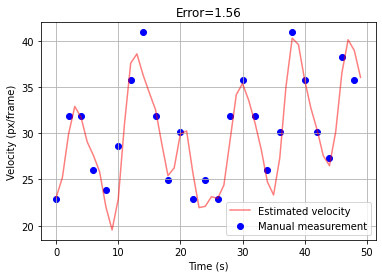

In [224]:
sample, pt = vf[25:75], np.array(vs_cls[1][25:75])
plt.plot(sample, 'r', alpha=0.5, label='Estimated velocity')

t = np.arange(0, len(sample), 2).astype('int')
points = np.array([t, pt[list(t)]])
print(points.shape)
plt.scatter(t, pt[list(t)], c='b', label='Manual measurement') 
plt.grid()
## error calculation
err = np.mean(np.abs(sample[list(t)] - pt[list(t)]))
plt.title(f'Error={err:.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (px/frame)')
plt.legend()
plt.show()

In [ ]:
np.mean(v)

15.446548015180179

In [ ]:
## 
mean_v = 40.19
mean_d = 29.60
mean_rate1 = mean_v*mean_d
print(mean_rate1)

mean_v = 36.39
mean_d = 30.65
mean_rate2 = mean_v*mean_d
print(mean_rate2)

mean_v = 37.10
mean_d = 33.22
mean_rate3 = mean_v*mean_d
print(mean_rate3)

mean_v = 31.35
mean_d = 36.00
mean_rate3 = mean_v*mean_d
print(mean_rate3)


mean_diff = mean_rate2 - mean_rate3
print(mean_diff/np.sqrt(mean_rate2*mean_rate3))

1189.624
1115.3535
1232.462
1128.6000000000001
-0.011806600102281363


In [ ]:
## ST diagram contrast adjustment
def ST_adjust(vid_centerline):
    vid_centerline_blur = gaussian_filter(vid_centerline, sigma=(0, 2.5))
    vid_thrsh = vid_centerline - np.mean(vid_centerline, axis=0)
    # vid_thrsh = vid_thrsh / np.std(vid_thrsh, axis=0)
    vid_thrsh = vid_thrsh - np.min(vid_thrsh)
    vid_thrsh = vid_thrsh / np.max(vid_thrsh)
    vid_ST = exposure.equalize_adapthist(vid_thrsh, clip_limit=0.03)
    # vid_ST = exposure.equalize_hist(vid_thrsh)
    # vid_ST = exposure.equalize_hist(vid_thrsh)
    vid_ST = vid_ST > np.mean(vid_ST) + 1.5*np.std(vid_ST)
    return vid_thrsh, vid_ST
## Find the most prominent line
def hough_peak_extract(vid_ST, threshold=0.6):
    h, theta, d = hough_line(vid_ST)
    h[:, 15:] = 0
    accum, angles, dists = hough_line_peaks(h, theta, d, threshold=vid_ST.shape[1]*threshold)
    return accum, angles, dists
def line_reconstruct(angle, dist, vid_ST_shape, edge_gap = 0):
    y0 = (dist - (edge_gap) * np.cos(angle)) / (np.sin(angle))
    y1 = (dist - (vid_ST_shape[1]-edge_gap) * np.cos(angle)) / (np.sin(angle))
    # print(y0, y1)
    rr, cc = line(int(y0), edge_gap, int(y1), vid_ST_shape[1]-1-edge_gap)
    rr = np.clip(rr, 0, vid_ST_shape[0]-1)
    cc = np.clip(cc, 0, vid_ST_shape[1]-1)
    return rr, cc, (np.floor(y0),np.ceil(y1))
# match for ROC
def match_detection(FP, gts):
    TP, FN = [],[]
    for gi, gt in enumerate(gts):
        is_match = False
        for pi, pred in enumerate(FP):
            if gt>=pred[0] and gt<=pred[1]:
                TP.append(gt)
                FP = np.delete(FP, pi, axis=0)
                is_match = True
                break
        if not is_match:
            FN.append(gt)
    Pre, Rec = len(TP)/(len(TP)+len(FP)+1e-5), len(TP)/(len(TP)+len(FN)+1e-5)
    F1 = 2*Pre*Rec/(Pre+Rec+1e-5)
    # print(len(TP), len(FN), len(FP))
    return Pre, Rec, F1

(261, 2)
(9238, 261)


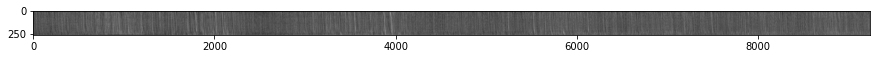

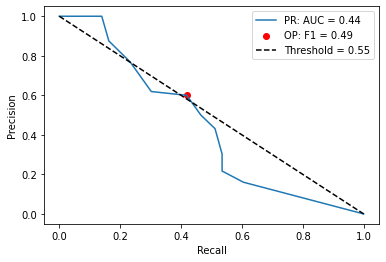

In [ ]:
# spotiotemporal diagram of the centerline
# vid_centerline = vid_enhanced[:, 
#                      centerline_coords[:, :, 0].astype(int), 
#                      centerline_coords[:, :, 1].astype(int)]
print(centerline_coords.shape)
vide_ceterline = [map_coordinates(frm,centerline_coords.T, order=1) for frm in vid_enhanced]
vid_centerline = np.array(vide_ceterline)
print(vid_centerline.shape)
vid_centerline_ori = vid_centerline.copy()
# vid_centerline_max = np.max(vid_centerline, axis=-1)
# vid_centerline = np.mean(vid_centerline, axis=-1)
vid_thrsh, vid_ST = ST_adjust(vid_centerline)

Precs, Recals, F1s = [], [], [] 
line_imgs = []

threshs = np.arange(0.3, 1., 0.05)
for thresh in threshs:
    fnum = []
    line_img = np.zeros_like(vid_ST)
    # accum, angles, dists = hough_peak_extract(vid_ST, thresh)
    # for angle, dist in zip(angles, dists):
    #     rr, cc, yy = line_reconstruct(angle, dist, vid_ST.shape, edge_gap=0)
    #     line_img[rr, cc] = 1
    #     fnum.append(yy)
    step = 2000
    for vi in range(0, vid_ST.shape[0], step):
        vid_seg = vid_ST[vi:vi+step,:]
        acc, ang, dis = hough_peak_extract(vid_seg[:,:], thresh)
        for angle, dist in zip(ang, dis):
            rr, cc, yy = line_reconstruct(angle, dist, vid_seg.shape, edge_gap=0)
            line_img[rr+vi, cc] = 1
            fnum.append(np.array(yy)+vi)
    if len(fnum) == 0:
        continue
    line_imgs.append(line_img)
    preds = np.array(fnum)
    pid = np.argsort(preds[:, 0])
    preds = preds[pid] 
    Prec, Recall, F1 = match_detection(preds, GT)
    # print(thresh, Prec, Recall, F1)
    Precs.append(Prec)
    Recals.append(Recall)
    F1s.append(F1)
idx = np.argmax(F1s)
thrsh_opt = threshs[idx]
plt.figure(figsize=(15, 5))
plt.imshow(vid_thrsh.T, cmap='gray')
rr, cc = np.where(line_imgs[idx])
# plt.scatter(rr, cc, c='r', s=1., alpha=0.5)
# plt.vlines(GT, 0, vid_thrsh.shape[1]-1, colors='g', linestyles='dashed')
plt.show()

opt_point = (Recals[idx], Precs[idx])
Precs  = [0] + Precs + [1]
Recals = [1] + Recals + [0]
# plot the Precision-Recall curve
plt.plot(Recals, Precs, label='PR')
plt.scatter(opt_point[0], opt_point[1], c='r')
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['PR: AUC = %.2f' % auc(Recals, Precs), 
            'OP: F1 = %.2f' % F1s[idx], 
            'Threshold = %.2f' % thrsh_opt])
plt.show()

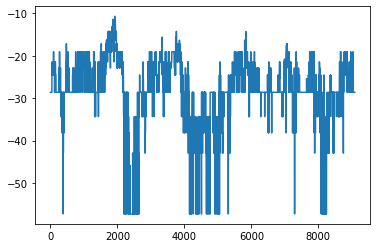

In [ ]:
# velocity estimation
time_window = 150
dist_window = 50
vs =[]
for t in range(0, vid_centerline.shape[0]-time_window, 1):
    vid_seg = vid_thrsh[t:t+time_window, 50:-50]
    vid_ST = vid_seg #exposure.equalize_adapthist(vid_seg, clip_limit=0.03)
    vid_ST1 = vid_ST > np.mean(vid_ST) + .5*np.std(vid_ST)
    vid_ST0 = vid_ST > np.mean(vid_ST) + 1.5*np.std(vid_ST)
    vid_ST = vid_ST1.astype(np.float32) - vid_ST0.astype(np.float32)
    vid_ST = vid_ST > 0
    line_img = np.zeros_like(vid_seg)
    
    acc, ang, dis = hough_peak_extract(vid_ST, 0.25)
    h, theta, d = hough_line(vid_ST)
    # print(np.median(ang))
    # for angle, dist in zip(ang, dis):
    #         rr, cc, yy = line_reconstruct(angle, dist, vid_seg.shape, edge_gap=0)
    #         line_img[rr, cc] = 1
    # # h[:, 15:] = 0
    # vels = np.std(h, axis=0)
    # vels = gaussian_filter(vels, sigma=1)
    # # plt.imshow(line_img.T, cmap='gray')
    # plt.imshow(vid_ST.T, cmap='gray', alpha=0.5)
    # rr, cc = np.where(line_img)
    # plt.scatter(rr, cc, c='r', s=1., alpha=0.5)
    # plt.show()
    num = len(ang)
    ang = np.sort(ang)[num//3:-num//3]
    vs.append(np.tan(np.mean(ang)))
plt.plot(vs)
plt.show()

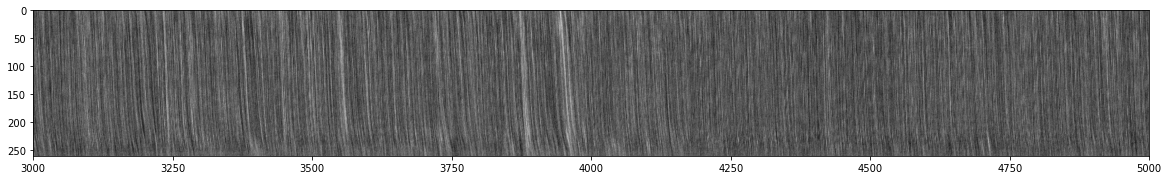

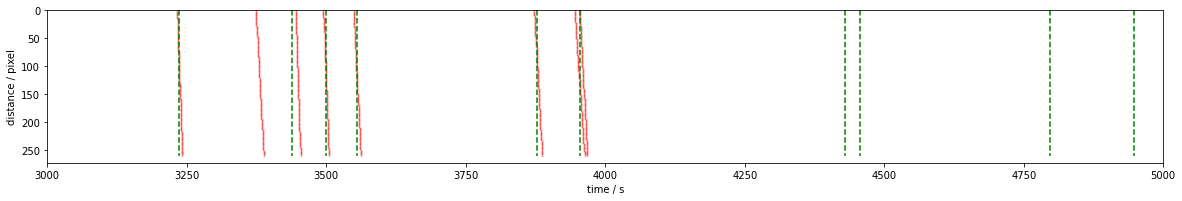

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(vid_thrsh[:,:].T, cmap='gray')
plt.xlim(3000, 5000)
plt.figure(figsize=(20, 5))
plt.imshow(vid_ST[:,:].T, cmap='gray')
rr, cc = np.where(line_imgs[idx])
plt.scatter(rr, cc, c='r', s=1., alpha=0.2)
plt.vlines(GT, 0, vid_thrsh.shape[1]-1, colors='g', linestyles='dashed')
plt.xlim(3000, 5000)
plt.xlabel('time / s')
plt.ylabel('distance / pixel')
plt.show()

In [ ]:
np.tan(-1.53)

-24.49841044183805

## 3. WBC Localization

In [ ]:
save_mode = False
# gaussian smooth vid_ST
# vid_centerline_smooth = vid_centerline_max - np.mean(vid_centerline, axis=0)
vid_centerline_smooth = gaussian_filter(vid_thrsh.astype(np.float32), (0., 4))
# # apply mean filter
# vid_centerline_smooth = uniform_filter(vid_thrsh.astype(np.float32), (1, 15))
# plt.imshow(vid_centerline_smooth.T, cmap='gray')
# plt.show()
vid_seg = vid_ST[:, 35:-35]
accum, angles, dists = hough_peak_extract(vid_seg, threshold=thrsh_opt)
match = []

# setup saving path
save_path = os.path.join('WBC')
frame_path = os.path.join(save_path, 'videos', vid_name)
anno_path = os.path.join(save_path, 'annotations')
gif_path = os.path.join(save_path, 'gifs', vid_name)
for p in [save_path, frame_path, anno_path, gif_path]:
    if not os.path.exists(p):
        os.makedirs(p)

anno_dict = {}
for angle, dist in zip(angles[:], dists[:]):
    rr, cc, _ = line_reconstruct(angle, dist, vid_ST.shape, edge_gap = 0)
    rr_unq = np.unique(rr)
    r_range = np.arange(np.floor(np.min(rr_unq)), np.ceil(np.max(rr_unq))).astype(int)
    match = [True for G in GT if G in r_range]
    if len(match) == 0: continue
    cs = []
    c_proir = -1
    vid_seg = vid_enhanced[r_range]
    # plt.imshow(np.mean(vid_seg, axis=0), cmap='gray')
    gifs, gifs_raw = [], []
    intensity = vid_centerline_smooth[r_range, :]
    cs = np.argmax(intensity, axis=1)
    # curvefit with r_range and cs
    difs = np.diff(cs)
    baseline = np.linspace(0, len(centerline_coords), len(r_range))
    plt.plot(r_range[:-1], difs)
    plt.plot(r_range, cs)
    plt.plot(r_range, baseline, 'r--')
    baseline_dict = {}
    for r_r, bs in zip(r_range, baseline):
            baseline_dict[r_r] = bs
    range_new = r_range.copy()
    while np.diff(cs).min() < 0:
        difs = np.diff(cs)
        idx = np.argmin(difs)
        if np.abs(baseline_dict[range_new[idx]]-cs[idx]) > np.abs(baseline_dict[range_new[idx+1]]-cs[idx+1]):
            cs = np.delete(cs, idx)
            range_new = np.delete(range_new, idx)
        else:
            cs = np.delete(cs, idx+1)
            range_new = np.delete(range_new, idx+1)
    f = interp1d(range_new, cs, fill_value='extrapolate') 
    cs = f(r_range)
    plt.plot(r_range, cs, 'green')
    plt.show()    

    # plt.figure(figsize=(20, 20))
    for ri, r in enumerate(r_range):
        mc = int(np.clip(cs[ri],0,len(centerline_coords)-1))
        ml = np.argmax(vid_centerline_ori[r, mc]) 
        mct = centerline_coords[mc, ml]
        # plt.subplot(4,4,ri%16+1)
        # plt.imshow(vid_enhanced[r], cmap='gray')   
        # plt.scatter(mct[1], mct[0], c='r', s=5)
        # plt.axis('off')
        im_save = np.zeros((vid_enhanced.shape[1], vid_enhanced.shape[2], 3))
        im_save[:,:,0] = vid[r]
        im_save[:,:,1] = vid[r]
        im_save[:,:,2] = vid[r]
        # add red point to im_save
        im_save[int(centerline_coords[mc, ml, 0])-2:int(centerline_coords[mc, ml, 0])+2, 
                int(centerline_coords[mc, ml, 1])-2:int(centerline_coords[mc, ml, 1])+2, 0] = 255.
        # save annotation point to dict
        anno_dict[str(r)] = {'file_name': '{}/WBC_{:04d}.png'.format(vid_name, r),
                            'center': (int(centerline_coords[mc, ml, 0]), int(centerline_coords[mc, ml, 1]))}
        gifs.append(im_save.astype('uint8'))
        if save_mode: imageio.imsave(os.path.join(frame_path, 'WBC_{:04d}.png'.format(r)), vid[r])

        # plt.imshow(im_save)
    # plt.show()

    if len(gifs) >= 5:
        print(r_range)
        # save the gif
        imageio.mimsave(os.path.join(gif_path,  'WBC_{}-{}.gif'.format(r_range[0],r_range[-1])), np.array(gifs), fps=2.5, format='GIF')

# save the annotation file into .json
if save_mode:
    import json
    with open(os.path.join(anno_path, '{}.json'.format(vid_name)), 'w') as f:
        json.dump(anno_dict, f)
    f.close()

In [ ]:
anno_dic

NameError: name 'anno_dic' is not defined

In [ ]:
import os
import zipfile
from glob import glob
import numpy as np
from read_roi import read_roi_file, read_roi_zip
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio.v3 as imageio

# Path to the .gif file
file_path = 'WBC_2310.gif'
# Read the .gif file
gif = imageio.imread(file_path)
print(gif.shape)
# #
# root_path = 'WBC_raw_2310.zip'

# new_gifs =[]
# ROI = read_roi_zip(root_path)
# for i, (key, value) in enumerate(ROI.items()):
#     print(key, value['x'], value['y'])
#     g = gif[i]
#     im_save = np.zeros((g.shape[0], g.shape[1], 3))
#     im_save[:,:,0] = g[:,:]
#     im_save[:,:,1] = g[:,:]
#     im_save[:,:,2] = g[:,:]
#     im_save[int(value['y'][-1])-3:int(value['y'][-1])+3, 
#             int(value['x'][-1])-3:int(value['x'][-1])+3, 1] = 255.
#     new_gifs.append(im_save)
# imageio.mimsave('WBC_2310_new.gif', new_gifs, fps=2.5)
        

TypeError: read() got an unexpected keyword argument 'format'

In [ ]:
# load .csv file
import pandas as pd
vid_name = 'P07_V01_01'
df = pd.read_csv('/Users/huangluojie/Desktop/Cytometry/MGH_Data/20231211/20231211_ManualCellCt.csv')
frames = df[f'{vid_name}; Frame'].values
# reomve NaN
frames = np.unique(frames[~np.isnan(frames)])
print(frames)  


[ 311.  433.  513.  905. 1266. 1559. 1630. 1640. 2023. 2212. 2225. 2585.
 2724. 2805. 2939. 3567. 3575. 4142. 4321. 5557. 5791. 5800. 5877. 6244.
 6364. 7386. 7389. 8126. 8385. 8392. 8435. 8450. 8847. 8899. 9122.]


(100, 476, 753)


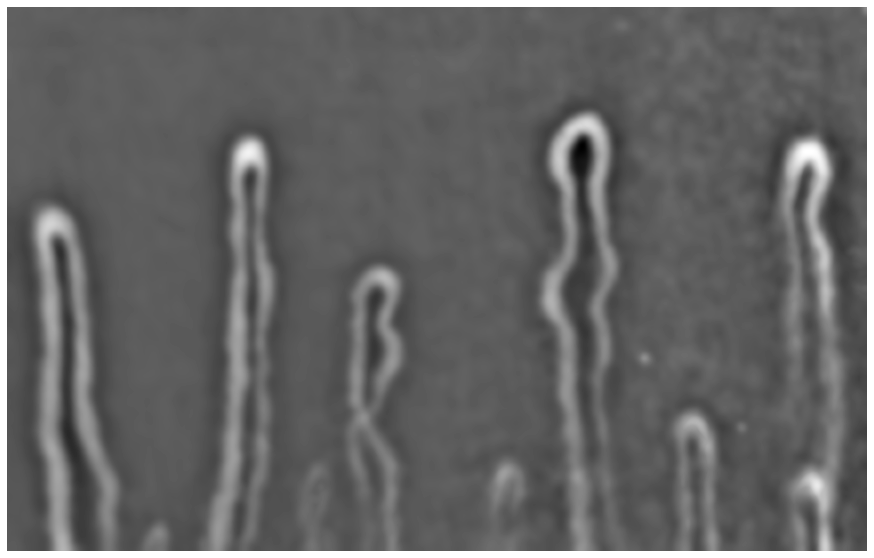

In [ ]:
# figure plot on nailfold

import os
import numpy as np
import matplotlib.pyplot as plt

figure_path = '/Users/huangluojie/Desktop/Cytometry/nailfold/jilly-20170517_150615-4-53-adj.webm'
# # load .wbm file
# cap = cv2.VideoCapture(figure_path)
# vid = []
# while True:
#     ret, frame = cap.read()
#     if ret:
#         vid.append(frame[:,:,0])
#     else:
#         break
tiff_path = '/Users/huangluojie/Desktop/Cytometry/nailfold/jilly-20170517_150615-4-53-adj.tif'
vid = tifffile.imread(tiff_path).astype(np.float32)
vid = np.array(vid)[225:325]
border = detect_border(vid)
vid = vid[:, border[1][0]:border[1][1], border[0][0]:border[0][1]]
print(vid.shape)
# vid_flow = np.std(vid, axis=0)
# vid_flow -= np.min(vid_flow)
# vid_flow /= np.max(vid_flow)

vid_inten = gaussian_filter(vid, sigma=3) 
vid_inten = np.min(vid_inten, axis=0)
vid_inten = -vid_inten / gaussian_filter(vid_inten, sigma=15)
vid_inten -= np.min(vid_inten)
vid_inten /= np.max(vid_inten)

vid_flow = vid_inten #vid_flow
vid_flow -= np.min(vid_flow)
vid_flow /= np.max(vid_flow)

plt.figure(figsize=(20, 10))
plt.imshow(vid_flow, cmap='gray')
plt.axis('off')
plt.show()

# # save vid as .tif file
# save_path = '/Users/huangluojie/Desktop/Cytometry/nailfold/jilly-20170517_150615-4-53-adj.tif'
# tifffile.imsave(save_path, vid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


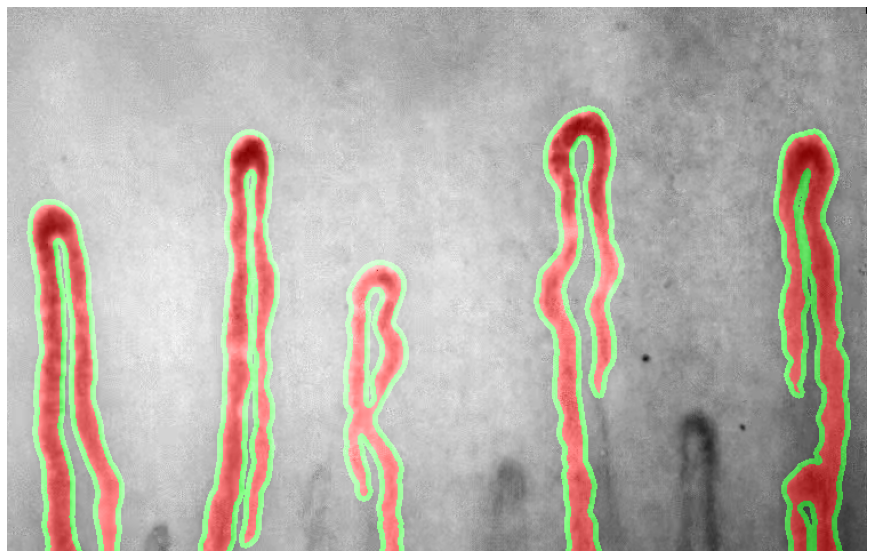

"\n# nailfold_ori = nailfold.copy()\n# # widefield flattenting\n# bg = nailfold.copy()\n# bg = gaussian_filter(bg, sigma=25, mode='reflect')\n\n# nailfold  =  nailfold/bg#gaussian_filter(nailfold, sigma=3, mode='nearest')/bg\n# nailfold = nailfold - np.min(nailfold)\n# nailfold = nailfold / np.max(nailfold)\n\n\n# from skimage import io, filters\n\n\n# mask = exposure.equalize_adapthist(nailfold, clip_limit=0.02, kernel_size=4)\n# mask = gaussian_filter(mask, sigma=3, mode='nearest')\n# mask = filters.threshold_local(mask, block_size=25, method='gaussian')\n# plt.imshow(mask, cmap='gray')\n# plt.show()\n# print(threshold)\n# mask = mask < (np.mean(mask) - .5*np.std(mask))\n# # remove small objects\n# # mask = morphology.binary_closing(mask, morphology.disk(2))\n# mask = morphology.remove_small_objects(mask, min_size=1200)\n# for i in range(2):\n#     mask = morphology.erosion(mask, morphology.disk(2))\n#     # mask = morphology.binary_closing(mask, morphology.disk(3))\n# mask = morphol

In [ ]:
# turn into binary mask with threshold
mask = vid_flow.copy()
mask = mask > (np.mean(mask) + .5 * np.std(mask))
# close holes & remove small objects
mask = morphology.binary_closing(mask, morphology.disk(2))
mask = morphology.remove_small_objects(mask, min_size=4000)
mask = morphology.binary_closing(mask, morphology.disk(2))

edge = mask.copy().astype(np.uint8)
# edge = morphology.binary_closing(edge, morphology.disk(18)).astype(np.float32)
# edge = morphology.dilation(edge, morphology.disk(5))
sobel = morphology.dilation(edge, morphology.disk(5)) - edge
# # Apply the Sobel edge detection filter
# sobelx = cv2.Sobel(edge, cv2.CV_64F, 1, 0, ksize=7)
# sobely = cv2.Sobel(edge, cv2.CV_64F, 0, 1, ksize=7)
# # Combine the Sobel edge detection results
# sobel = np.hypot(sobelx, sobely)
# sobel = morphology.erosion(sobel, morphology.disk(2))
# mask = morphology.erosion(mask, morphology.disk(2))

disp = np.zeros((vid.shape[1], vid.shape[2], 3))
disp = np.repeat(vid[0][:,:,None], 3, axis=-1)
disp -= np.min(disp)
disp /= np.max(disp)
disp[:,:,0] += 0.5*mask
disp[:,:,1] += 0.5*sobel
plt.figure(figsize=(20, 10))
plt.imshow(disp, cmap='gray')
plt.axis('off')
plt.show()
# # detect connected objects in mask
# import skimage.measure as measure
# label = measure.label(mask)
# props = measure.regionprops(label)
# # sort the objects by area
# areas = [p.area for p in props]
# idx = np.argsort(areas)[::-1]
# # get the largest object
# for i in range(1, len(idx)):
#     mask = label == idx[i]+1
#     smoothed_mask = smooth_contour(mask, n=1, disk_size=1, epsilon=0.0008)

#     plt.figure(figsize=(20, 10))
#     plt.imshow(smoothed_mask, cmap='gray')
#     plt.axis('off')
#     plt.show()
'''
# nailfold_ori = nailfold.copy()
# # widefield flattenting
# bg = nailfold.copy()
# bg = gaussian_filter(bg, sigma=25, mode='reflect')

# nailfold  =  nailfold/bg#gaussian_filter(nailfold, sigma=3, mode='nearest')/bg
# nailfold = nailfold - np.min(nailfold)
# nailfold = nailfold / np.max(nailfold)


# from skimage import io, filters


# mask = exposure.equalize_adapthist(nailfold, clip_limit=0.02, kernel_size=4)
# mask = gaussian_filter(mask, sigma=3, mode='nearest')
# mask = filters.threshold_local(mask, block_size=25, method='gaussian')
# plt.imshow(mask, cmap='gray')
# plt.show()
# print(threshold)
# mask = mask < (np.mean(mask) - .5*np.std(mask))
# # remove small objects
# # mask = morphology.binary_closing(mask, morphology.disk(2))
# mask = morphology.remove_small_objects(mask, min_size=1200)
# for i in range(2):
#     mask = morphology.erosion(mask, morphology.disk(2))
#     # mask = morphology.binary_closing(mask, morphology.disk(3))
# mask = morphology.remove_small_objects(mask, min_size=50)
# for i in range(2):
#     mask = morphology.dilation(mask, morphology.disk(2))

# edge = mask.copy().astype(np.uint8)
# edge = morphology.binary_closing(edge, morphology.disk(15)).astype(np.float32)
# edge = morphology.dilation(edge, morphology.disk(5))-edge
# mask = morphology.remove_small_objects(mask, min_size=50)
# # for i in range(2):
# #     mask = morphology.dilation(mask, morphology.disk(2))
# # mask = smooth_contour(mask, n=3, disk_size=5)

# disp = np.zeros((nailfold.shape[0], nailfold.shape[1], 3))
# disp[:,:,0] = nailfold + 0.5*mask
# disp[:,:,1] = nailfold #+ 0.5*edge
# disp[:,:,2] = nailfold
# plt.figure(figsize=(20, 10))
# plt.imshow(disp, cmap='gray')
# plt.axis('off')
# plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow(mask, cmap='gray')
# plt.axis('off')
# plt.show()
'''


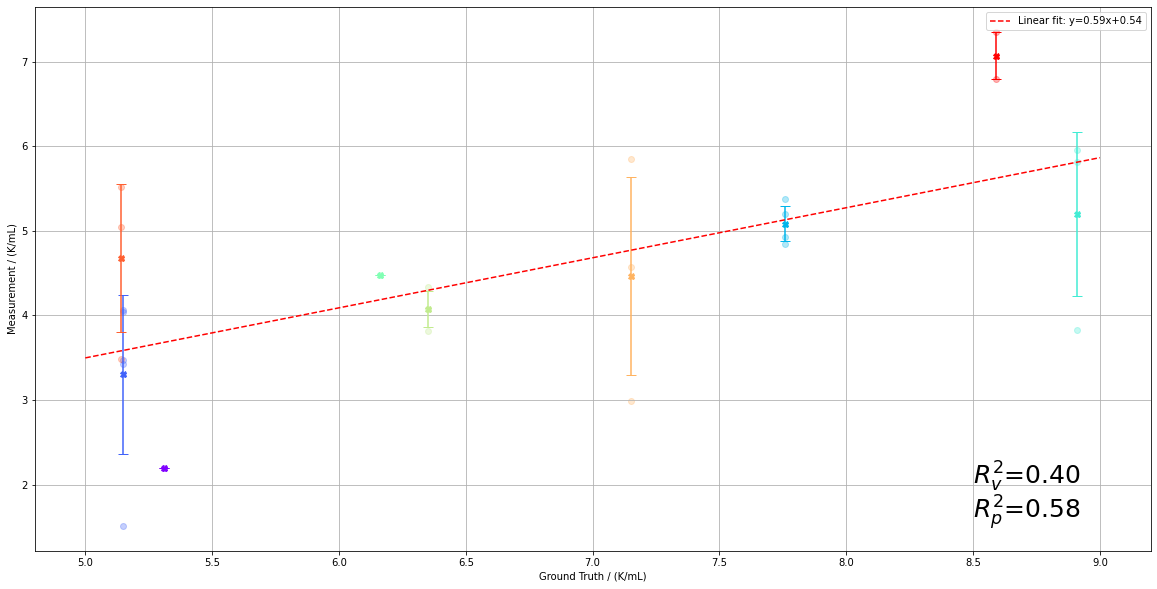

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


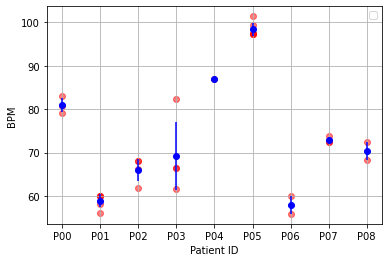

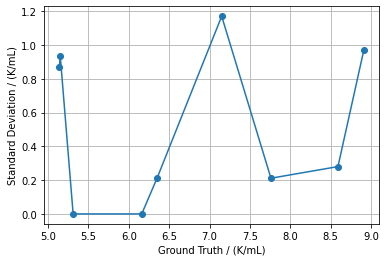

In [28]:
# results plot
Comp ={}
Comp['P00'] = {'GT': 5.31,
               'measure':[2.20, 11.39], #, 5.77
               'volume': [0.0149, 0.0059, 0.0099],
               'BPM': [79.1, 83.05, 80.77]}
Comp['P01'] = {'GT': 5.15,
               'measure':[4.06, 1.51, 4.04, 3.43, 3.47],
               'volume': [0.0116, 0.0079, 0.0136, 0.0131, 0.0130],
               'BPM': [58.21, 56.18, 60, 60, 60]}
Comp['P02'] = {'GT': 7.76,
               'measure':[5.37, 5.20, 4.93, 4.84],
               'volume': [0.0037, 0.0067, 0.0071, 0.0101], 
               'BPM': [61.86, 68.04, 68.04, 66.21]}
Comp['P03'] = {'GT': 8.91,
               'measure':[5.95, 19.78, 16.75, 5.81, 3.83],
               'volume': [0.0087, 0.0049, 0.0057, 0.0074, 0.0112], 
               'BPM': [82.26, 66.38 , 66.38, 61.57]}
Comp['P04'] = {'GT': 6.16,
               'measure':[4.48],
               'volume': [0.0083], 
               'BPM': [86.96]}
Comp['P05'] = {'GT': 6.35,
               'measure':[4.08,  18.10, 3.81, 4.33],  #6.81, 5.98
               'volume': [0.0253, 0.0103, 0.0027, 0.0045, 0.0116, 0.0077], 
               'BPM': [101.38, 99.31, 97.24, 97.24, 97.62, 97.24]}
Comp['P06'] = {'GT': 7.15,
               'measure':[5.85, 4.57, 2.99],
               'volume': [0.0121, 0.0039, 0.0023], 
               'BPM': [55.86, 60]}
Comp['P07'] = {'GT': 5.14,
               'measure':[5.52, 5.04, 3.48],
               'volume': [0.0072, 0.0046, 0.0034], 
               'BPM': [73.71, 72.41, 72.41]}
Comp['P08'] = {'GT': 8.59,
               'measure':[6.79, 7.35],
               'volume': [0.0035, 0.0038], 
               'BPM': [72.41, 68.28]}
# Comp['P09'] = {'GT': 5.09,
#                'measure':[5.26, 1.96, 4.12],
#                'volume': [0.0030, 0.0036, 0.0061], 
#                'BPM': [82.01, 88.8, 90.65]}
# Comp['P10'] = {'GT': 7.82,
#                'measure':[6.90, 6.56, 4.87], # , 2.96, 10.83
#                'volume': [0.0030, 0.0021, 0.0029], 
#                'BPM': [78.62, 84.83, 84.83, 82.76, 88.97]}
# Comp['P11'] = {'GT': 5.26,
#                'measure':[3.46, 1.99],
#                'volume': [0.0032, 0.0025], 
#                'BPM': [68.42, 68.42]}
# Comp['P12'] = {'GT': 7.31,
#                'measure':[3.60, 6.73],
#                'volume': [0.0072, 0.0083], 
#                'BPM': [57.89, 60]}

from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 1, len(Comp)))
plt.figure(figsize=(20, 10))
GTs, Measures, Means, GTs_p = [], [], [], []
stds = []
for i, (key, value) in enumerate(Comp.items()):
    mmean, mstd = np.mean(value['measure']), np.std(value['measure'])
    # if len(value['measure']) > 3:
    #     mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume']) if m<mmean+1.5*mstd and m>mmean-1.5*mstd])
    # else:
    #   mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume'])])
    mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume']) if m<10.])
    ms, vs = mvs[:,0], mvs[:,1]
    gts = [value['GT']]*len(ms)
    p = plt.scatter(gts, ms, color=colors[i], alpha = 0.3)
    mean, error  = np.mean(ms), np.std(ms)
    stds.append(error)
    mean_w =np.sum(ms*vs)/np.sum(vs)
    plt.errorbar(value['GT'], mean, yerr=error, fmt='X-', capsize=5, color=colors[i])
    # plt.scatter(value['GT'], mean_w, color=colors[i], marker='D')
    # plt.text(value['GT'], mean, key, fontsize=15, color=colors[i], horizontalalignment = 'left')
    GTs.append(gts)
    GTs_p.append(value['GT'])
    Measures.append(ms)
    Means.append([mean])
GTs, Measures, Means = np.concatenate(GTs), np.concatenate(Measures), np.concatenate(Means)
# linear fit GTs and Measures
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(GTs, Measures)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(GTs_p, Means)
x = np.linspace(5, 9, 100)
y = slope*x + intercept
plt.plot(x, y, 'r--', label = f'Linear fit: y={slope:.2f}x+{intercept:.2f}')
y1 = slope1*x + intercept1
# plt.plot(x, y1, 'b--', label = f'Linear fit: y={slope1:.2f}x+{intercept1:.2f}')
plt.legend()
plt.grid()
plt.text(8.5, 2, f'$R^2_v$={r_value**2:.2f}', fontsize=25)
plt.text(8.5, 1.6, f'$R^2_p$={r_value1**2:.2f}', fontsize=25)
plt.xlabel('Ground Truth / (K/mL)')
plt.ylabel('Measurement / (K/mL)')
plt.show()

# plt.figure(figsize=(20, 10))
for i, (key, value) in enumerate(Comp.items()):
   plt.scatter([i]*len(value['BPM']), value['BPM'], color='r', alpha = 0.5)
   plt.errorbar(i, np.mean(value['BPM']), yerr=np.std(value['BPM']), fmt='o', color='b')
plt.legend()
plt.grid()
plt.xticks(np.arange(len(Comp)), Comp.keys())
plt.xlabel('Patient ID')
plt.ylabel('BPM')
plt.show()

idx  = np.argsort(GTs_p)
GTs_p, stds = np.array(GTs_p)[idx], np.array(stds)[idx]
plt.plot(GTs_p, stds, 'o-')
plt.xlabel('Ground Truth / (K/mL)')ß
plt.ylabel('Standard Deviation / (K/mL)')
plt.grid()
plt.show()

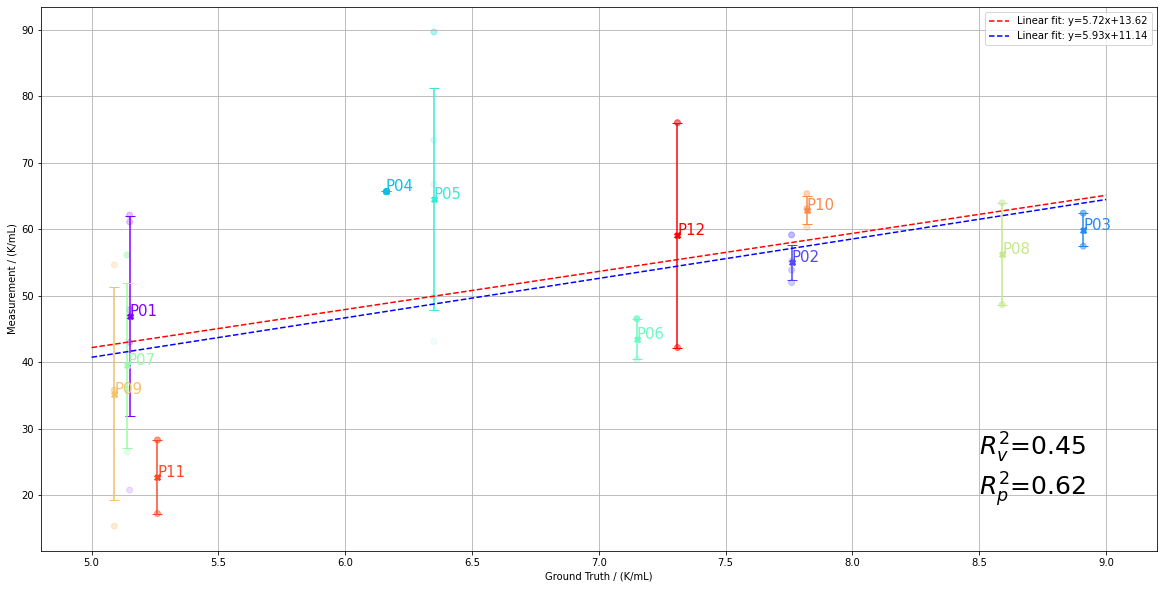

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


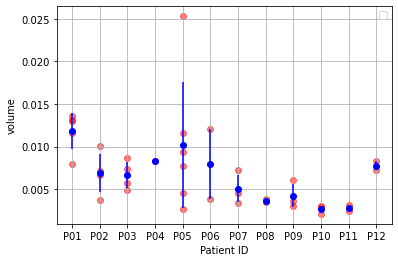

In [ ]:
# results plot
Comp ={}
# Comp['P00'] = {'GT': 5.31,
#                'measure':[31.00, 76.74, 139.45],
#                'volume': [0.0149, 0.0059, 0.0099],
#                'BPM': [79.1, 83.05, 80.77]}
Comp['P01'] = {'GT': 5.15,
               'measure':[43.00, 20.81, 62.12, 47.90, 61.11],
               'volume': [0.0116, 0.0079, 0.0136, 0.0131, 0.0130],
               'BPM': [58.21, 56.18, 60, 60, 60]}
Comp['P02'] = {'GT': 7.76,
               'measure':[55.27, 53.87, 51.99, 59.15],
               'volume': [0.0037, 0.0067, 0.0071, 0.0101], 
               'BPM': [61.86, 68.04, 68.04, 66.21]}
Comp['P03'] = {'GT': 8.91,
               'measure':[62.41, 206.43, 192.74, 57.46],
               'volume': [0.0087, 0.0049, 0.0057, 0.0074], 
               'BPM': [82.26, 66.38 , 66.38, 61.57]}
Comp['P04'] = {'GT': 6.16,
               'measure':[65.74],
               'volume': [0.0083], 
               'BPM': [86.96]}
Comp['P05'] = {'GT': 6.35,
               'measure':[89.65, 73.37, 178.25, 43.12, 49.86, 66.75],
               'volume': [0.0253, 0.0094, 0.0027, 0.0045, 0.0116, 0.0077], 
               'BPM': [101.38, 99.31, 97.24, 97.24, 97.62, 97.24]}
Comp['P06'] = {'GT': 7.15,
               'measure':[46.55, 40.46], #, 2.99
               'volume': [0.0121, 0.0039], 
               'BPM': [55.86, 60]}
Comp['P07'] = {'GT': 5.14,
               'measure':[56.13, 35.99, 26.50],
               'volume': [0.0072, 0.0046, 0.0034], 
               'BPM': [73.71, 72.41, 72.41]}
Comp['P08'] = {'GT': 8.59,
               'measure':[63.97, 48.68],
               'volume': [0.0035, 0.0038], 
               'BPM': [72.41, 68.28]}
Comp['P09'] = {'GT': 5.09,
               'measure':[54.64, 15.40, 35.85],
               'volume': [0.0030, 0.0036, 0.0061], 
               'BPM': [82.01, 88.8, 90.65]}
Comp['P10'] = {'GT': 7.82,
               'measure':[63.12, 60.29, 65.34], # , 2.96, 10.83
               'volume': [0.0030, 0.0021, 0.0029], 
               'BPM': [78.62, 84.83, 84.83, 82.76, 88.97]}
Comp['P11'] = {'GT': 5.26,
               'measure':[28.33, 17.29],
               'volume': [0.0032, 0.0025], 
               'BPM': [68.42, 68.42]}
Comp['P12'] = {'GT': 7.31,
               'measure':[42.23, 76.01],
               'volume': [0.0072, 0.0083], 
               'BPM': [57.89, 60]}

from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 1, len(Comp)))
plt.figure(figsize=(20, 10))
GTs, Measures, Means, GTs_p = [], [], [], []
for i, (key, value) in enumerate(Comp.items()):
    mmean, mstd = np.mean(value['measure']), np.std(value['measure'])
    # if len(value['measure']) > 3:
    #     mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume']) if m<mmean+1.5*mstd and m>mmean-1.5*mstd])
    # else:
    #   mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume'])])
    mvs = np.array([(m,v) for m, v in zip(value['measure'], value['volume']) if m<100.])
    ms, vs = mvs[:,0], mvs[:,1]
    gts = [value['GT']]*len(ms)
    p = plt.scatter(gts, ms, color=colors[i], alpha = vs/np.sum(vs))
    mean, error  = np.mean(ms), np.std(ms)
    mean_w =np.sum(ms*vs)/np.sum(vs)
    plt.errorbar(value['GT'], mean, yerr=error, fmt='X-', capsize=5, color=colors[i])
    # plt.scatter(value['GT'], mean_w, color=colors[i], marker='D')
    plt.text(value['GT'], mean, key, fontsize=15, color=colors[i], horizontalalignment = 'left')
    GTs.append(gts)
    GTs_p.append(value['GT'])
    Measures.append(ms)
    Means.append([mean])
GTs, Measures, Means = np.concatenate(GTs), np.concatenate(Measures), np.concatenate(Means)
# linear fit GTs and Measures
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(GTs, Measures)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(GTs_p, Means)
x = np.linspace(5, 9, 100)
y = slope*x + intercept
plt.plot(x, y, 'r--', label = f'Linear fit: y={slope:.2f}x+{intercept:.2f}')
y1 = slope1*x + intercept1
plt.plot(x, y1, 'b--', label = f'Linear fit: y={slope1:.2f}x+{intercept1:.2f}')
plt.legend()
plt.grid()
plt.text(8.5, 26., f'$R^2_v$={r_value:.2f}', fontsize=25)
plt.text(8.5, 20., f'$R^2_p$={r_value1:.2f}', fontsize=25)
plt.xlabel('Ground Truth / (K/mL)')
plt.ylabel('Measurement / (K/mL)')
plt.show()

# plt.figure(figsize=(20, 10))
for i, (key, value) in enumerate(Comp.items()):
   plt.scatter([i]*len(value['volume']), value['volume'], color='r', alpha = 0.5)
   plt.errorbar(i, np.mean(value['volume']), yerr=np.std(value['volume']), fmt='o', color='b')
plt.legend()
plt.grid()
plt.xticks(np.arange(len(Comp)), Comp.keys())
plt.xlabel('Patient ID')
plt.ylabel('volume')
plt.show()